In [1]:
!pip install dython


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import KDTree
from sklearn.neighbors import BallTree
from sklearn.linear_model import LinearRegression
from scipy.interpolate import make_interp_spline
from sklearn.model_selection import train_test_split



In [3]:
base = "Data"

df_train = pd.read_csv(f"{base}/train.csv")
df_test = pd.read_csv(f'{base}/test.csv')

df_hdb = pd.read_csv(f'{base}/auxiliary-data/sg-hdb-block-details.csv')
df_mrt = pd.read_csv(f'{base}/auxiliary-data/sg-mrt-stations.csv')
df_shopping = pd.read_csv(f'{base}/auxiliary-data/sg-shopping-malls.csv')
df_hawker = pd.read_csv(f'{base}/auxiliary-data/sg-gov-hawkers.csv')
df_primary_schools = pd.read_csv(f'{base}/auxiliary-data/sg-primary-schools.csv')
df_secondary_schools = pd.read_csv(f'{base}/auxiliary-data/sg-secondary-schools.csv')

# Data Cleaning

In [4]:
def clean_train_test_dataframe(df, is_test=False):
    def floor_range_avg(rng):
        upper, lower = rng.split(" to ")
        upper = int(upper)
        lower = int(lower)
        return (upper + lower)/2

    df['BLOCK'] = df['BLOCK'].str.strip().str.lower()
    df['STREET'] = df['STREET'].str.strip().str.lower()

    df["ADDRESS"] = df['BLOCK'] + " " + df['STREET']

    df['FLAT_TYPE'] = df['FLAT_TYPE'].str.replace('-', ' ').str.strip().str.lower()

    df['YEAR'] = df['MONTH'].str.split('-').str[0].astype(int)
    df['MONTH'] = df['MONTH'].str.split('-').str[1].astype(int)

    df["FLOOR"] = df["FLOOR_RANGE"].apply(floor_range_avg)
    df["FLAT_AGE"] = df["YEAR"] - df["LEASE_COMMENCE_DATA"]

    df = df.drop('ECO_CATEGORY', axis=1)
    df = df.drop('FLOOR_RANGE', axis=1)
    df = df.drop('BLOCK', axis=1)
    df = df.drop('STREET', axis=1)

    if not is_test:
        df.drop_duplicates(inplace=True)

    return df

In [5]:
def clean_df_hdb(df):
    df["ADDRESS"] = df["ADDRESS"].str.strip().str.lower()
    df["BLOCK"] = df["BLOCK"].str.strip().str.lower()

    df["ADDRESS"] = df["BLOCK"] + " " + df["ADDRESS"]

    return df.drop('BLOCK', axis=1)

def remove_near_duplicate_schools(df):
    df = df.drop_duplicates(subset=['LATITUDE', 'LONGITUDE'], keep='last')
    return df

In [6]:
df_train = clean_train_test_dataframe(df_train)
df_test = clean_train_test_dataframe(df_test, is_test=True)

df_hdb = clean_df_hdb(df_hdb)

df_primary_schools = remove_near_duplicate_schools(df_primary_schools)
df_secondary_schools = remove_near_duplicate_schools(df_secondary_schools)

In [7]:
df_train

MONTH           TOWN FLAT_TYPE  FLOOR_AREA_SQM         FLAT_MODEL  \
0          10      woodlands    4 room           102.0  premium apartment   
1           7         bishan    4 room           104.0            model a   
2           5  bukit panjang    4 room           102.0            model a   
3           8        punggol    4 room            93.0            model a   
4           5        hougang    5 room           113.0           improved   
...       ...            ...       ...             ...                ...   
162686      7        hougang    4 room            91.0     new generation   
162687      9      pasir ris    4 room           104.0            model a   
162688     10        geylang    4 room            84.0         simplified   
162689      8       sengkang    5 room           110.0           improved   
162690      3        hougang    4 room            84.0         simplified   

        LEASE_COMMENCE_DATA  RESALE_PRICE                    ADDRESS  YEAR  \
0                      2000      420000.0    681b woodlands drive 62  2020   
1                      1992      585000.0       264 bishan street 24  2021   
2                      1998      450000.0          520 jelapang road  2021   
3                      2017      465000.0       121b edgedale plains  2021   
4                      2018      710000.0     997b buangkok crescent  2023   
...                     ...           ...                        ...   ...   
162686                 1985      335000.0       708 hougang avenue 2  2017   
162687                 1995      388000.0      634 pasir ris drive 1  2020   
162688                 1985      373000.0           319 ubi avenue 1  2017   
162689                 2001      420000.0  290b compassvale crescent  2020   
162690                 1987      355000.0      512 hougang avenue 10  2021   

        FLOOR  FLAT_AGE  
0         8.0        20  
1         8.0        29  
2        20.0        23  
3        17.0         4  
4        11.0         5  
...       ...       ...  
162686    2.0        32  
162687    5.0        25  
162688   11.0        32  
162689    2.0        19  
162690    2.0        34  

[162464 rows x 11 columns]

# Data Augmentation

In [8]:
def convert_to_coordinates(df, df_coords):
    df = df.merge(
        df_coords[['ADDRESS', 'LATITUDE', 'LONGITUDE', 'MAX_FLOOR']],
        on=['ADDRESS'],
        how='left'
    )
    return df

def calculate_distance_and_metadata(feature, df_features, df_main, meta_cols=None):
    tree = BallTree(np.radians(df_features[['LATITUDE', 'LONGITUDE']].to_numpy()), metric='haversine')
    distances, indices = tree.query(np.radians(df_main[['LATITUDE', 'LONGITUDE']].to_numpy()), k=10)
    distances_km = distances * 6371

    df_main[f"DIST_MIN_{feature}"] = np.min(distances_km, axis=1)
    df_main[f"DIST_AVG_{feature}"] = np.mean(distances_km, axis=1)
    df_main[f"DIST_MAX_{feature}"] = np.max(distances_km, axis=1)

    if meta_cols:
        nearest_idx = indices[:, 0]
        for col in meta_cols:
            df_main[f"{feature}_{col}"] = df_features.iloc[nearest_idx][col].values



def augment_auxiliary_data(df, mrt, shopping, hawker, primary_schools, secondary_schools):
    calculate_distance_and_metadata("MRT", mrt, df, meta_cols=["STATUS"])
    calculate_distance_and_metadata("OPEN_MRT", mrt[mrt["STATUS"] == "open"], df)
    calculate_distance_and_metadata("SHOPPING_MALL", shopping, df)
    calculate_distance_and_metadata(
        "HAWKER_CENTRE", hawker, df,
        meta_cols=["TYPE", "OWNER", "NUMBER_OF_STALLS"]
    )
    calculate_distance_and_metadata("PRIMARY_SCHOOL", primary_schools, df)
    calculate_distance_and_metadata("SECONDARY_SCHOOL", secondary_schools, df)
    return df


In [9]:
df_train = convert_to_coordinates(df_train, df_hdb)
df_test = convert_to_coordinates(df_test, df_hdb)

df_train = augment_auxiliary_data(df_train, df_mrt, df_shopping, df_hawker, df_primary_schools, df_secondary_schools)
df_test = augment_auxiliary_data(df_test, df_mrt, df_shopping, df_hawker, df_primary_schools, df_secondary_schools)

In [10]:
df_train

MONTH           TOWN FLAT_TYPE  FLOOR_AREA_SQM         FLAT_MODEL  \
0          10      woodlands    4 room           102.0  premium apartment   
1           7         bishan    4 room           104.0            model a   
2           5  bukit panjang    4 room           102.0            model a   
3           8        punggol    4 room            93.0            model a   
4           5        hougang    5 room           113.0           improved   
...       ...            ...       ...             ...                ...   
162459      7        hougang    4 room            91.0     new generation   
162460      9      pasir ris    4 room           104.0            model a   
162461     10        geylang    4 room            84.0         simplified   
162462      8       sengkang    5 room           110.0           improved   
162463      3        hougang    4 room            84.0         simplified   

        LEASE_COMMENCE_DATA  RESALE_PRICE                    ADDRESS  YEAR  \
0                      2000      420000.0    681b woodlands drive 62  2020   
1                      1992      585000.0       264 bishan street 24  2021   
2                      1998      450000.0          520 jelapang road  2021   
3                      2017      465000.0       121b edgedale plains  2021   
4                      2018      710000.0     997b buangkok crescent  2023   
...                     ...           ...                        ...   ...   
162459                 1985      335000.0       708 hougang avenue 2  2017   
162460                 1995      388000.0      634 pasir ris drive 1  2020   
162461                 1985      373000.0           319 ubi avenue 1  2017   
162462                 2001      420000.0  290b compassvale crescent  2020   
162463                 1987      355000.0      512 hougang avenue 10  2021   

        FLOOR  ...  DIST_MAX_HAWKER_CENTRE  HAWKER_CENTRE_TYPE  \
0         8.0  ...                9.331377                  HC   
1         8.0  ...                2.099000                 MHC   
2        20.0  ...                7.618905                 MHC   
3        17.0  ...                7.002855                 MHC   
4        11.0  ...                4.563702                  HC   
...       ...  ...                     ...                 ...   
162459    2.0  ...                4.550236                 MHC   
162460    5.0  ...                6.194957                 MHC   
162461   11.0  ...                2.375231                 MHC   
162462    2.0  ...                6.542880                 MHC   
162463    2.0  ...                4.833139                 MHC   

        HAWKER_CENTRE_OWNER  HAWKER_CENTRE_NUMBER_OF_STALLS  \
0                       HDB                              78   
1                       HDB                             118   
2                Government                             179   
3                       HDB                             186   
4                Government                              36   
...                     ...                             ...   
162459                  HDB                             186   
162460                  HDB                             144   
162461                  HDB                             110   
162462                  HDB                             186   
162463                  HDB                             186   

        DIST_MIN_PRIMARY_SCHOOL  DIST_AVG_PRIMARY_SCHOOL  \
0                      0.168452                 1.186822   
1                      0.532114                 1.493487   
2                      0.156784                 1.243942   
3                      0.177318                 0.870008   
4                      0.812018                 1.171904   
...                         ...                      ...   
162459                 0.558921                 1.224402   
162460                 0.126215                 1.687278   
162461                 0.256516                 1.929194

# Univariate Analysis

In [11]:
def plot_univariate_analysis_numerical(df, numeric_cols):
    n = len(numeric_cols)
    ncols = 3
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 5*nrows))
    axes = axes.flatten()

    for i, feature_name in enumerate(numeric_cols):
        ax = axes[i]

        counts, bins, _ = ax.hist(
            df[feature_name], bins=50, color='skyblue', edgecolor='white', alpha=0.8
        )
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        nonzero_mask = counts > 0
        bin_centers = bin_centers[nonzero_mask]
        counts = counts[nonzero_mask]

        if len(bin_centers) > 3:
            x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 300)
            spline = make_interp_spline(bin_centers, counts, k=3)
            y_smooth = spline(x_smooth)
            y_smooth = np.clip(y_smooth, 0, None)
            ax.plot(x_smooth, y_smooth, color='darkblue', lw=1.8)
        else:
            ax.plot(bin_centers, counts, color='darkblue', lw=1.8)

        ax.axvline(df[feature_name].mean(), color='red', linestyle='--', label='Mean')
        ax.axvline(df[feature_name].median(), color='yellow', linestyle='--', label='Median')

        ax.set_title(f'Distribution of {feature_name}', fontsize=12)
        ax.legend()

        feature = df[feature_name]
        summary_stats = '\n'.join((
            f'Mean: {feature.mean():.2f}',
            f'Median: {feature.median():.2f}',
            f'Max: {feature.max():.2f}',
            f'Min: {feature.min():.2f}',
            f'Std: {feature.std():.2f}',
            f'Skew: {feature.skew():.2f}',
            f'Kurt: {feature.kurt():.2f}'
        ))
        ax.text(
            0.98, 0.98, summary_stats,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
        )

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



def plot_univariate_analysis_categorical(df, cat_cols):
    n = len(cat_cols)
    ncols = 3
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 10*nrows))
    axes = axes.flatten()

    for i, feature_name in enumerate(cat_cols):
        ax = axes[i]
        order = df[feature_name].value_counts().index

        sns.countplot(x=feature_name, data=df, order=order, ax=ax)

        ax.set_title(f'{feature_name} (Unique: {df[feature_name].nunique()})', fontsize=12)
        ax.set_xlabel('')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=90)

        total = len(df)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percent = 100 * height / total
                ax.annotate(
                    f'{int(height)}\n({percent:.3f}%)',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom',
                    fontsize=8,
                    xytext=(0, 3),
                    textcoords='offset points'
                )

        summary_text = (
            f'Unique: {df[feature_name].nunique()}\n'
            f'Top: {df[feature_name].mode()[0]}\n'
            f'Mode %: {100 * df[feature_name].value_counts(normalize=True).iloc[0]:.1f}%'
        )
        ax.text(
            0.98, 0.98, summary_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
        )

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



### Univariate analysis for Numeric Fields

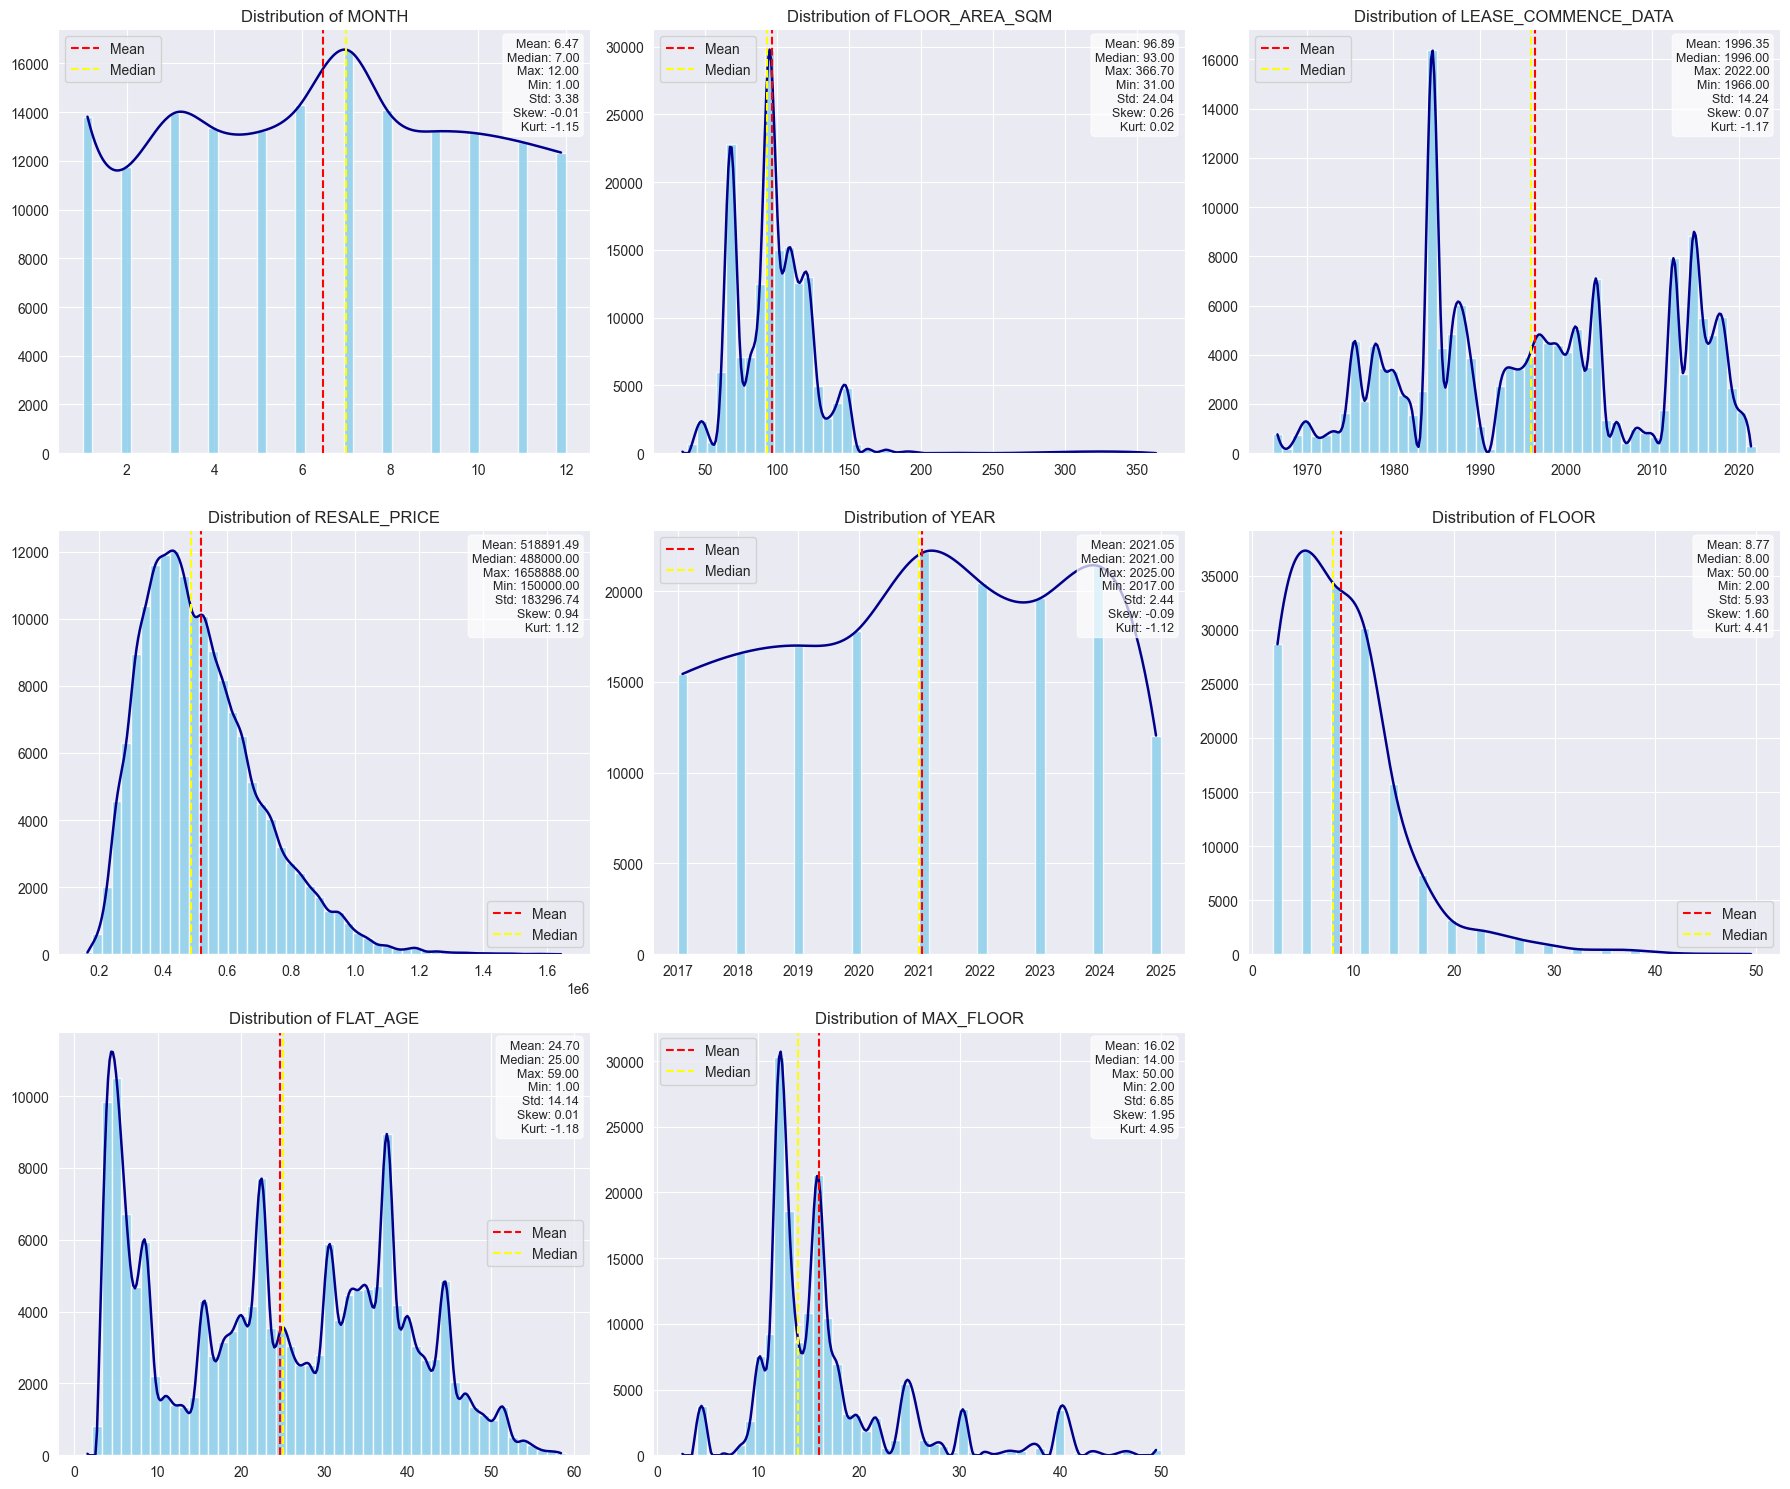

In [12]:
plot_univariate_analysis_numerical(df_train, numeric_cols=[
    'MONTH',
    'FLOOR_AREA_SQM',
    'LEASE_COMMENCE_DATA',
    'RESALE_PRICE',
    'YEAR',
    'FLOOR',
    'FLAT_AGE',
    'MAX_FLOOR'
])


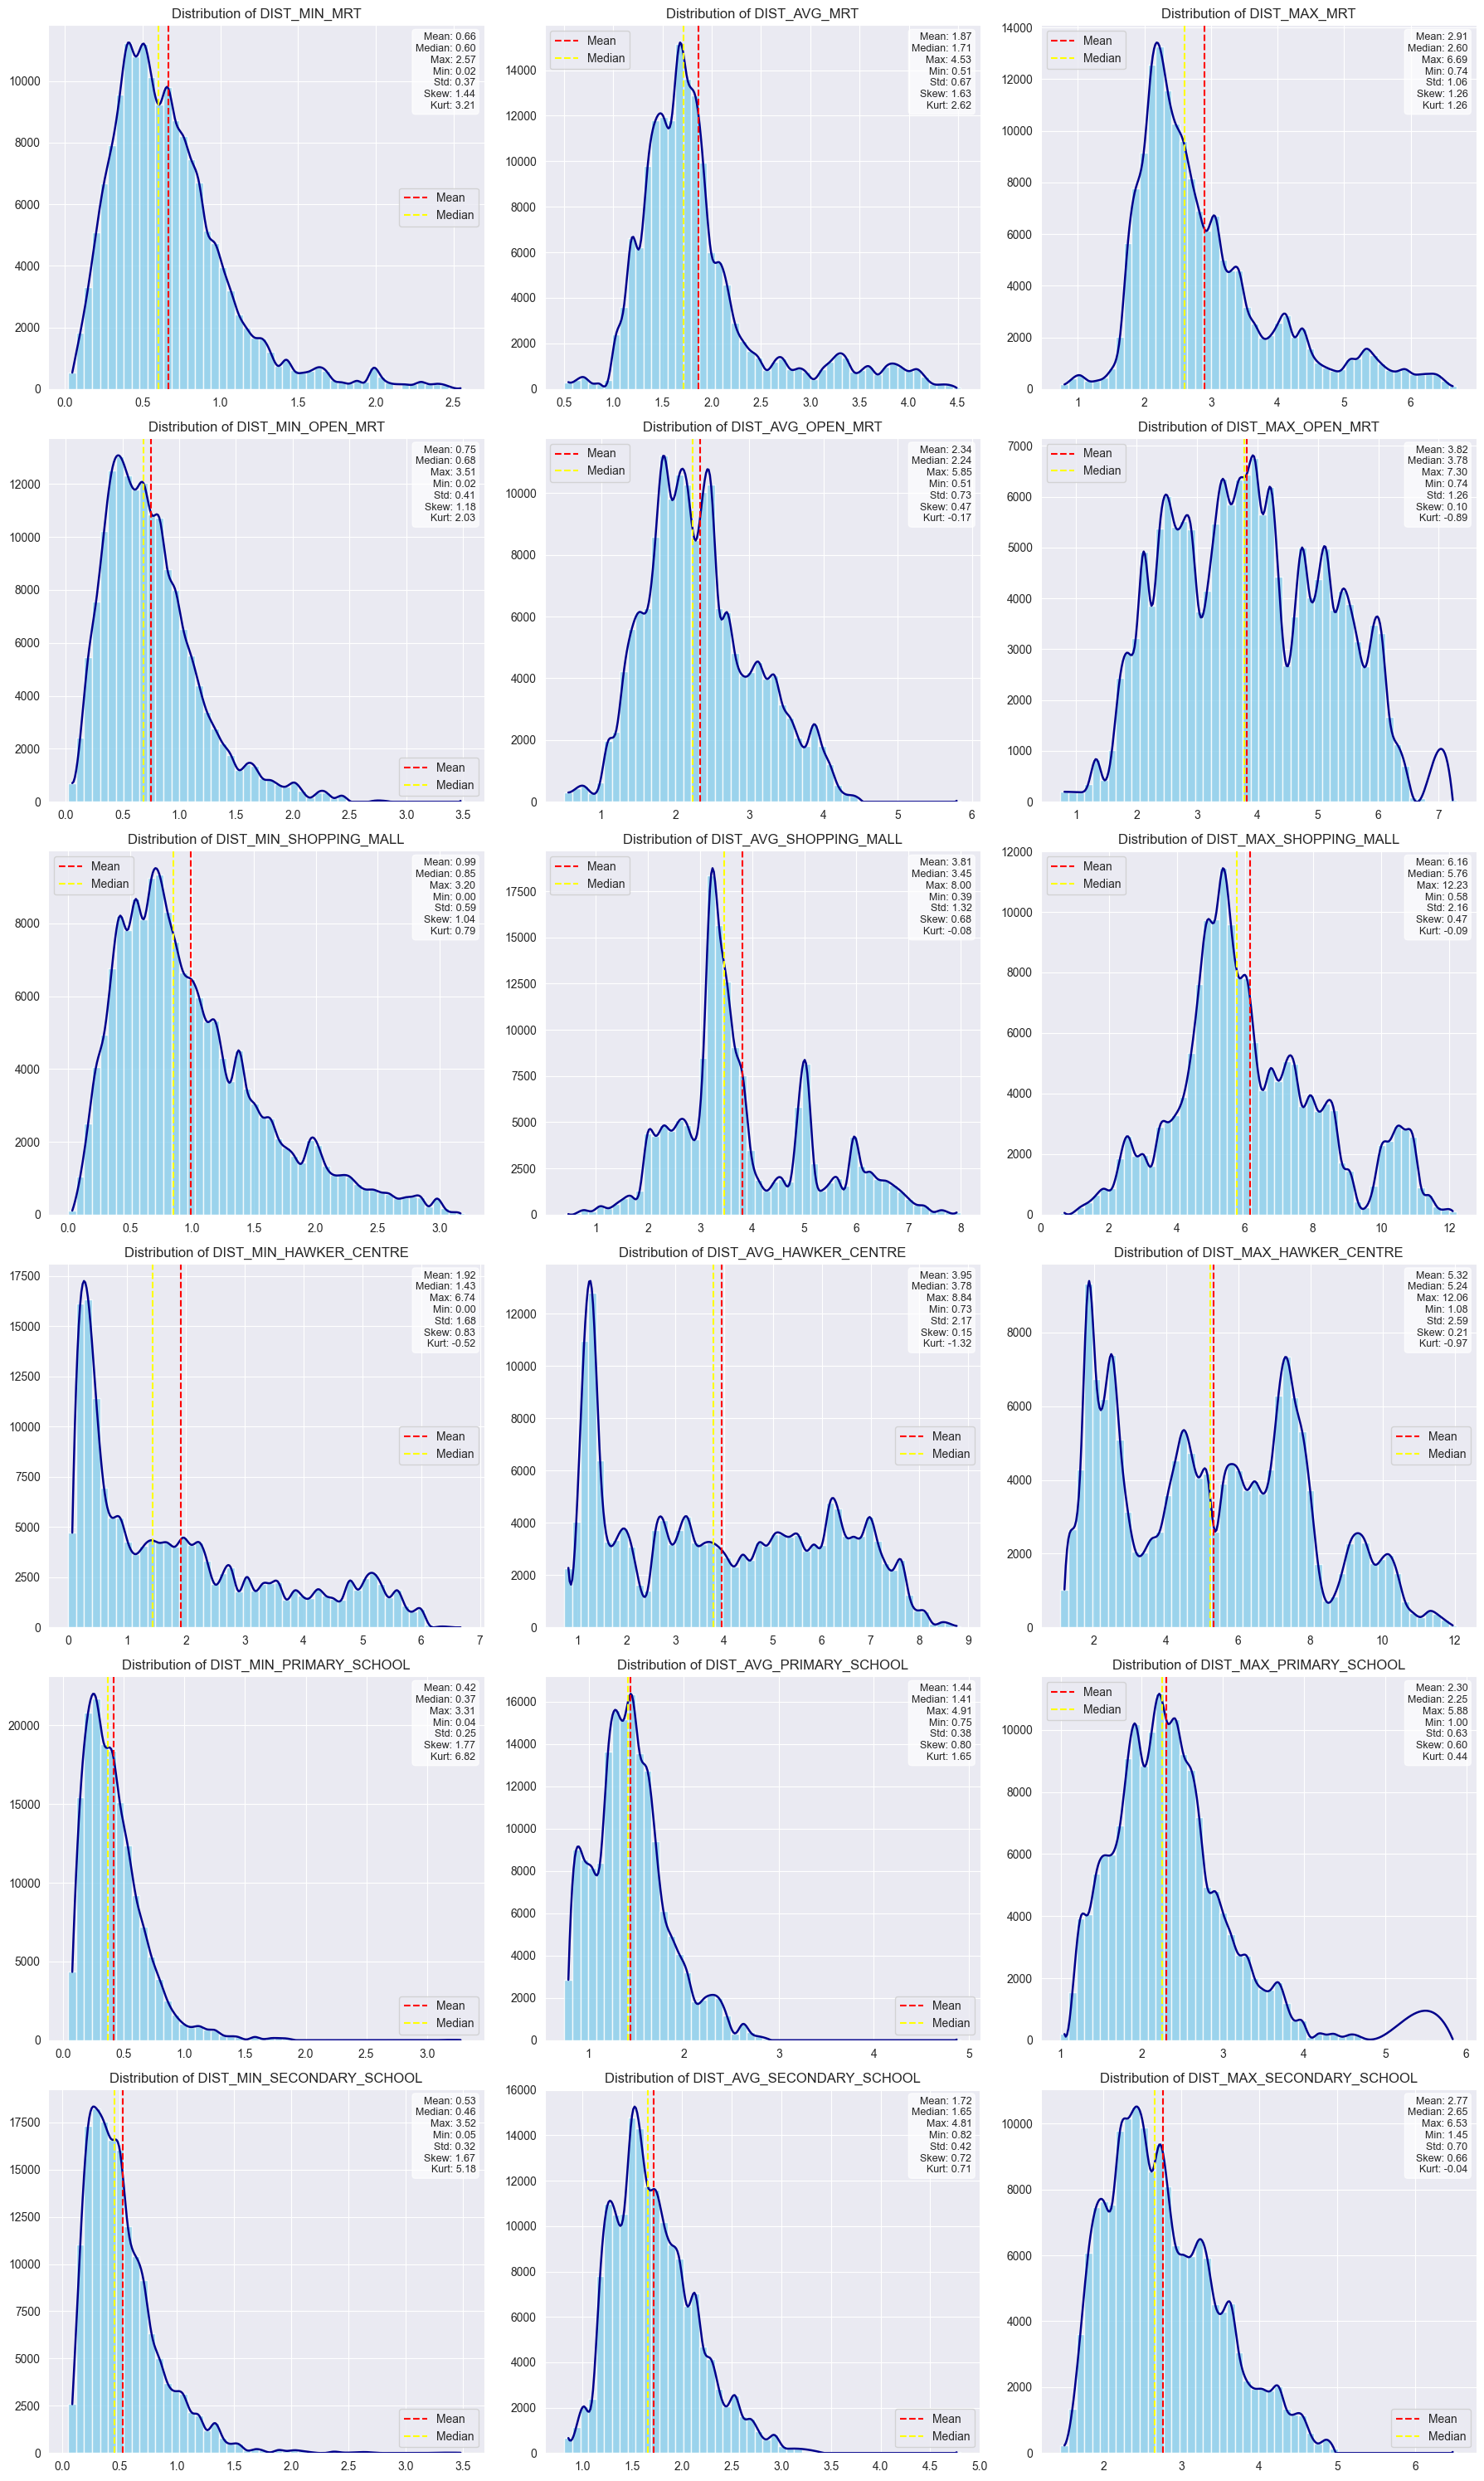

In [13]:
plot_univariate_analysis_numerical(df_train, numeric_cols=[
'DIST_MIN_MRT',
 'DIST_AVG_MRT',
 'DIST_MAX_MRT',
 'DIST_MIN_OPEN_MRT',
 'DIST_AVG_OPEN_MRT',
 'DIST_MAX_OPEN_MRT',
 'DIST_MIN_SHOPPING_MALL',
 'DIST_AVG_SHOPPING_MALL',
 'DIST_MAX_SHOPPING_MALL',
 'DIST_MIN_HAWKER_CENTRE',
 'DIST_AVG_HAWKER_CENTRE',
 'DIST_MAX_HAWKER_CENTRE',
 'DIST_MIN_PRIMARY_SCHOOL',
 'DIST_AVG_PRIMARY_SCHOOL',
 'DIST_MAX_PRIMARY_SCHOOL',
 'DIST_MIN_SECONDARY_SCHOOL',
 'DIST_AVG_SECONDARY_SCHOOL',
 'DIST_MAX_SECONDARY_SCHOOL'
])


### Univariate analysis for Categorical Fields

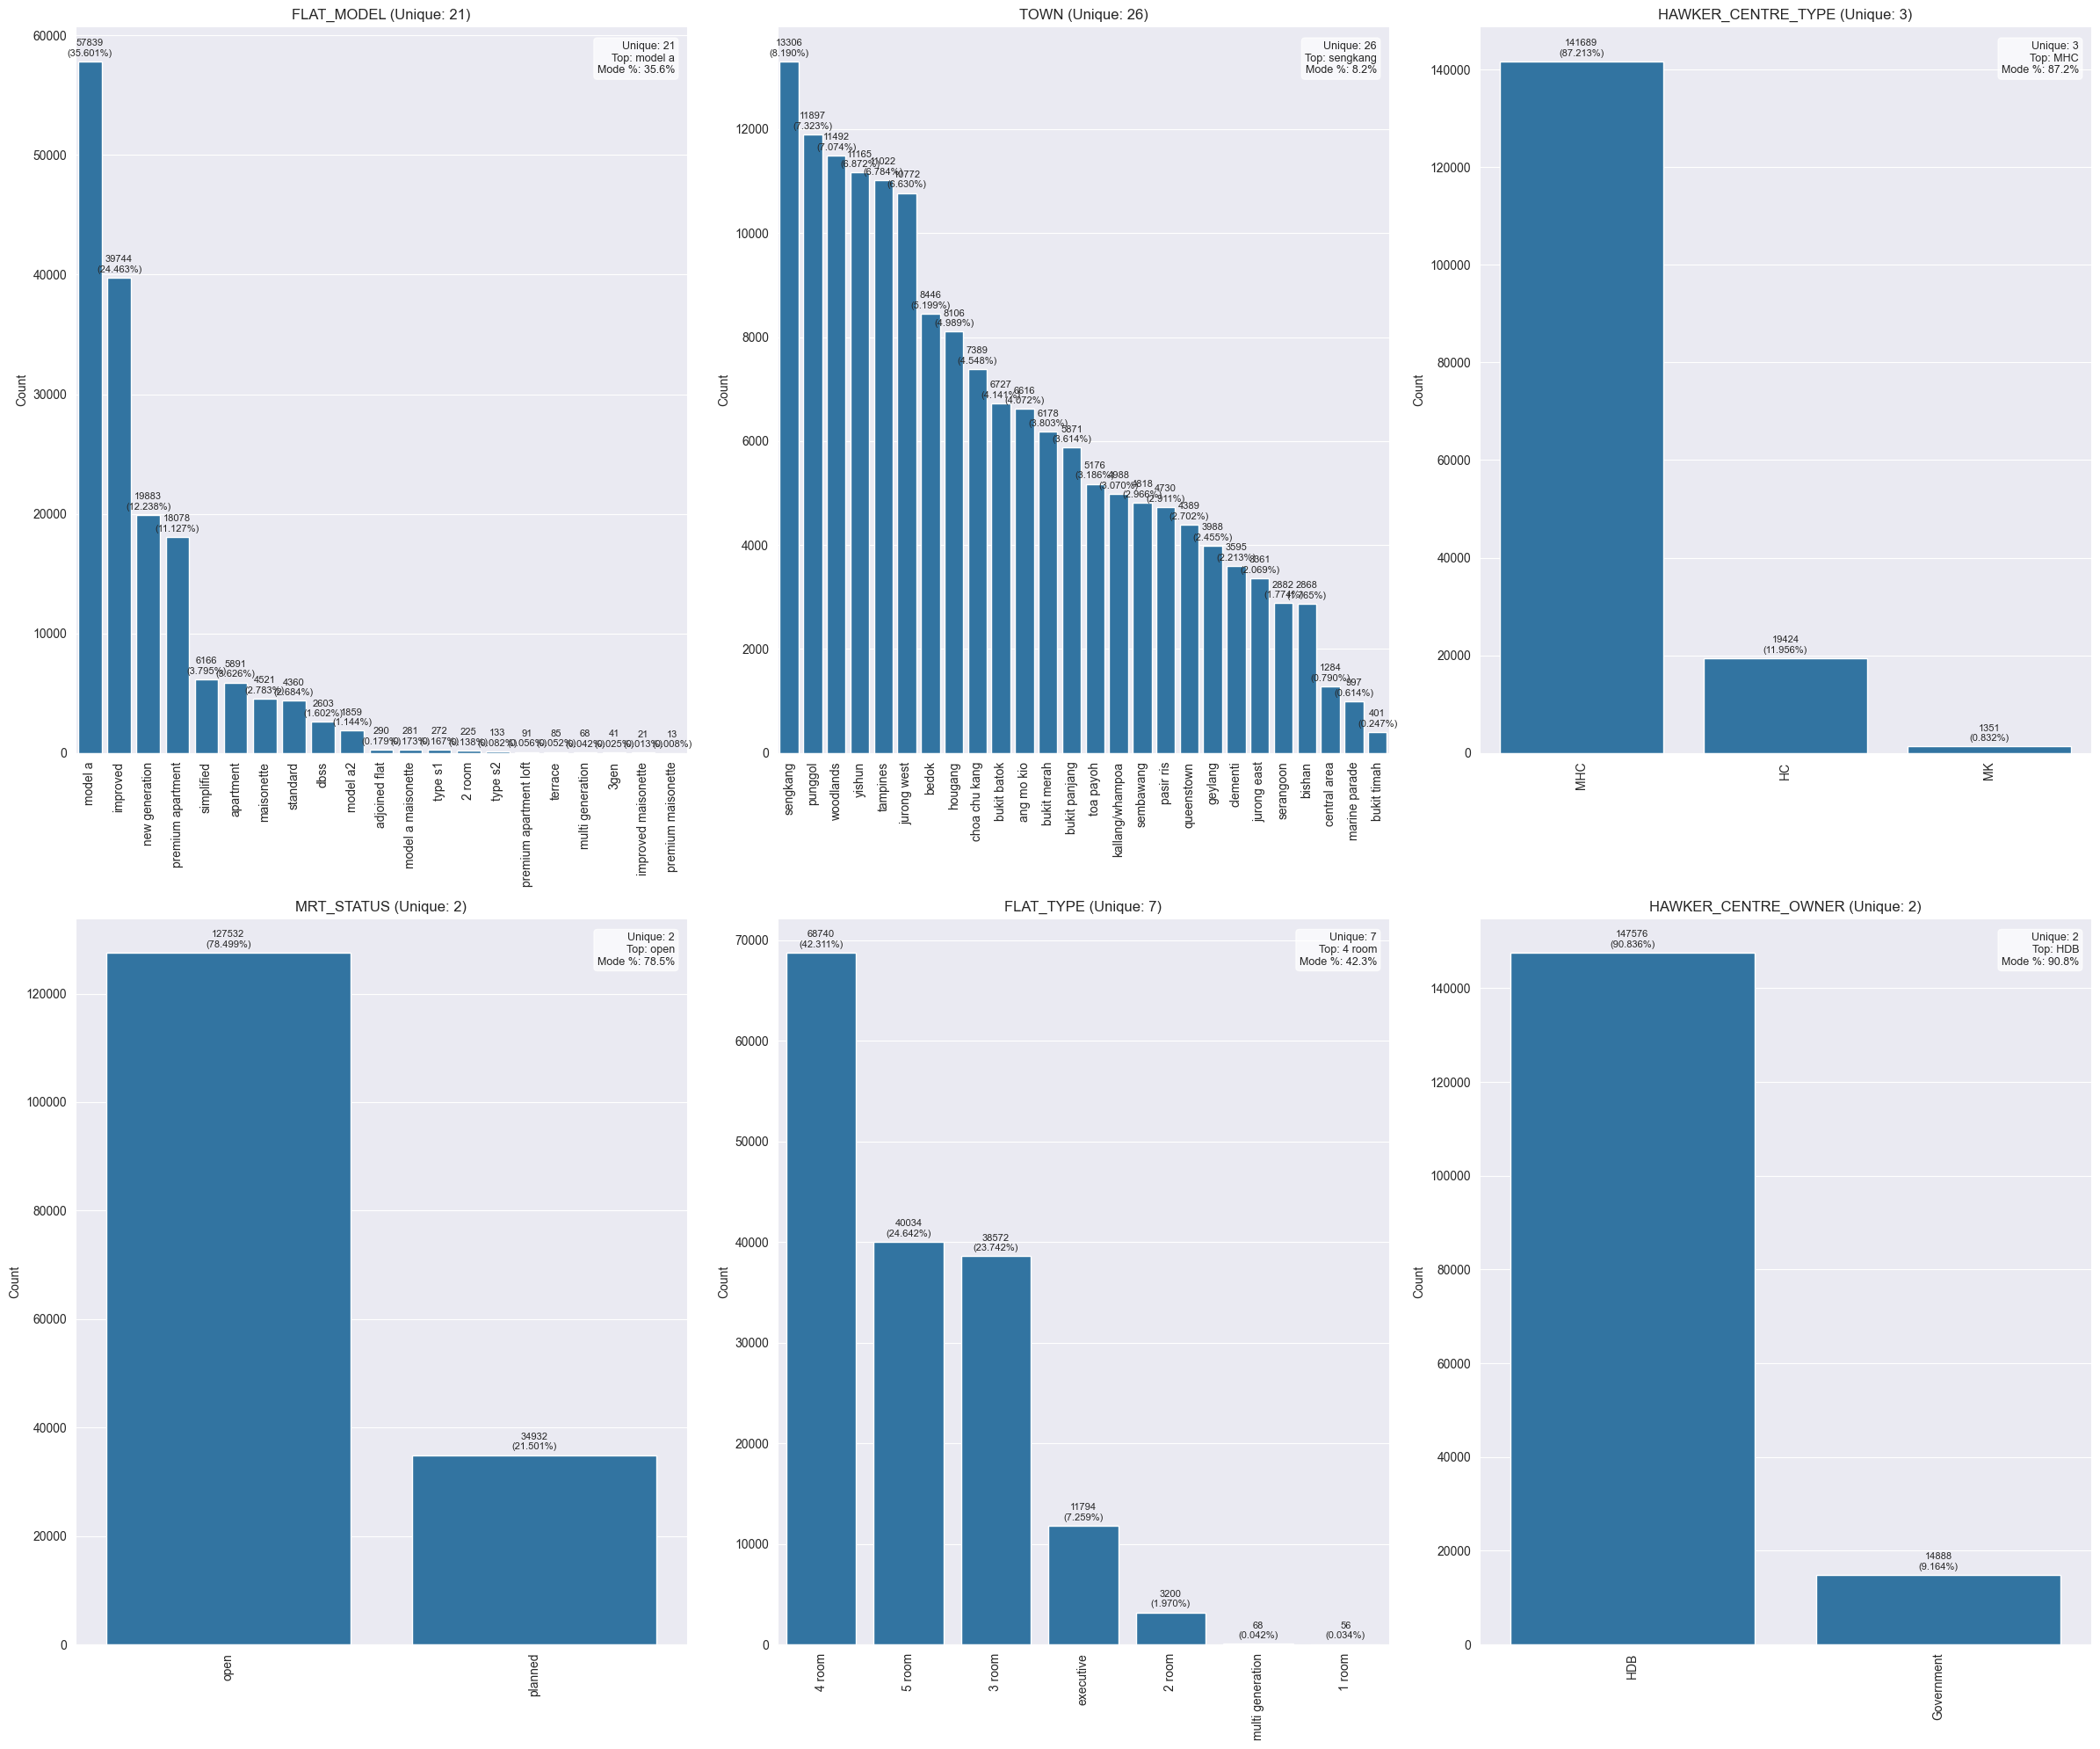

In [14]:
plot_univariate_analysis_categorical(
    df_train,
    ['FLAT_MODEL',
     'TOWN',
     'HAWKER_CENTRE_TYPE',
     'MRT_STATUS',
     'FLAT_TYPE',
     'HAWKER_CENTRE_OWNER']
)

# Bivariate analysis

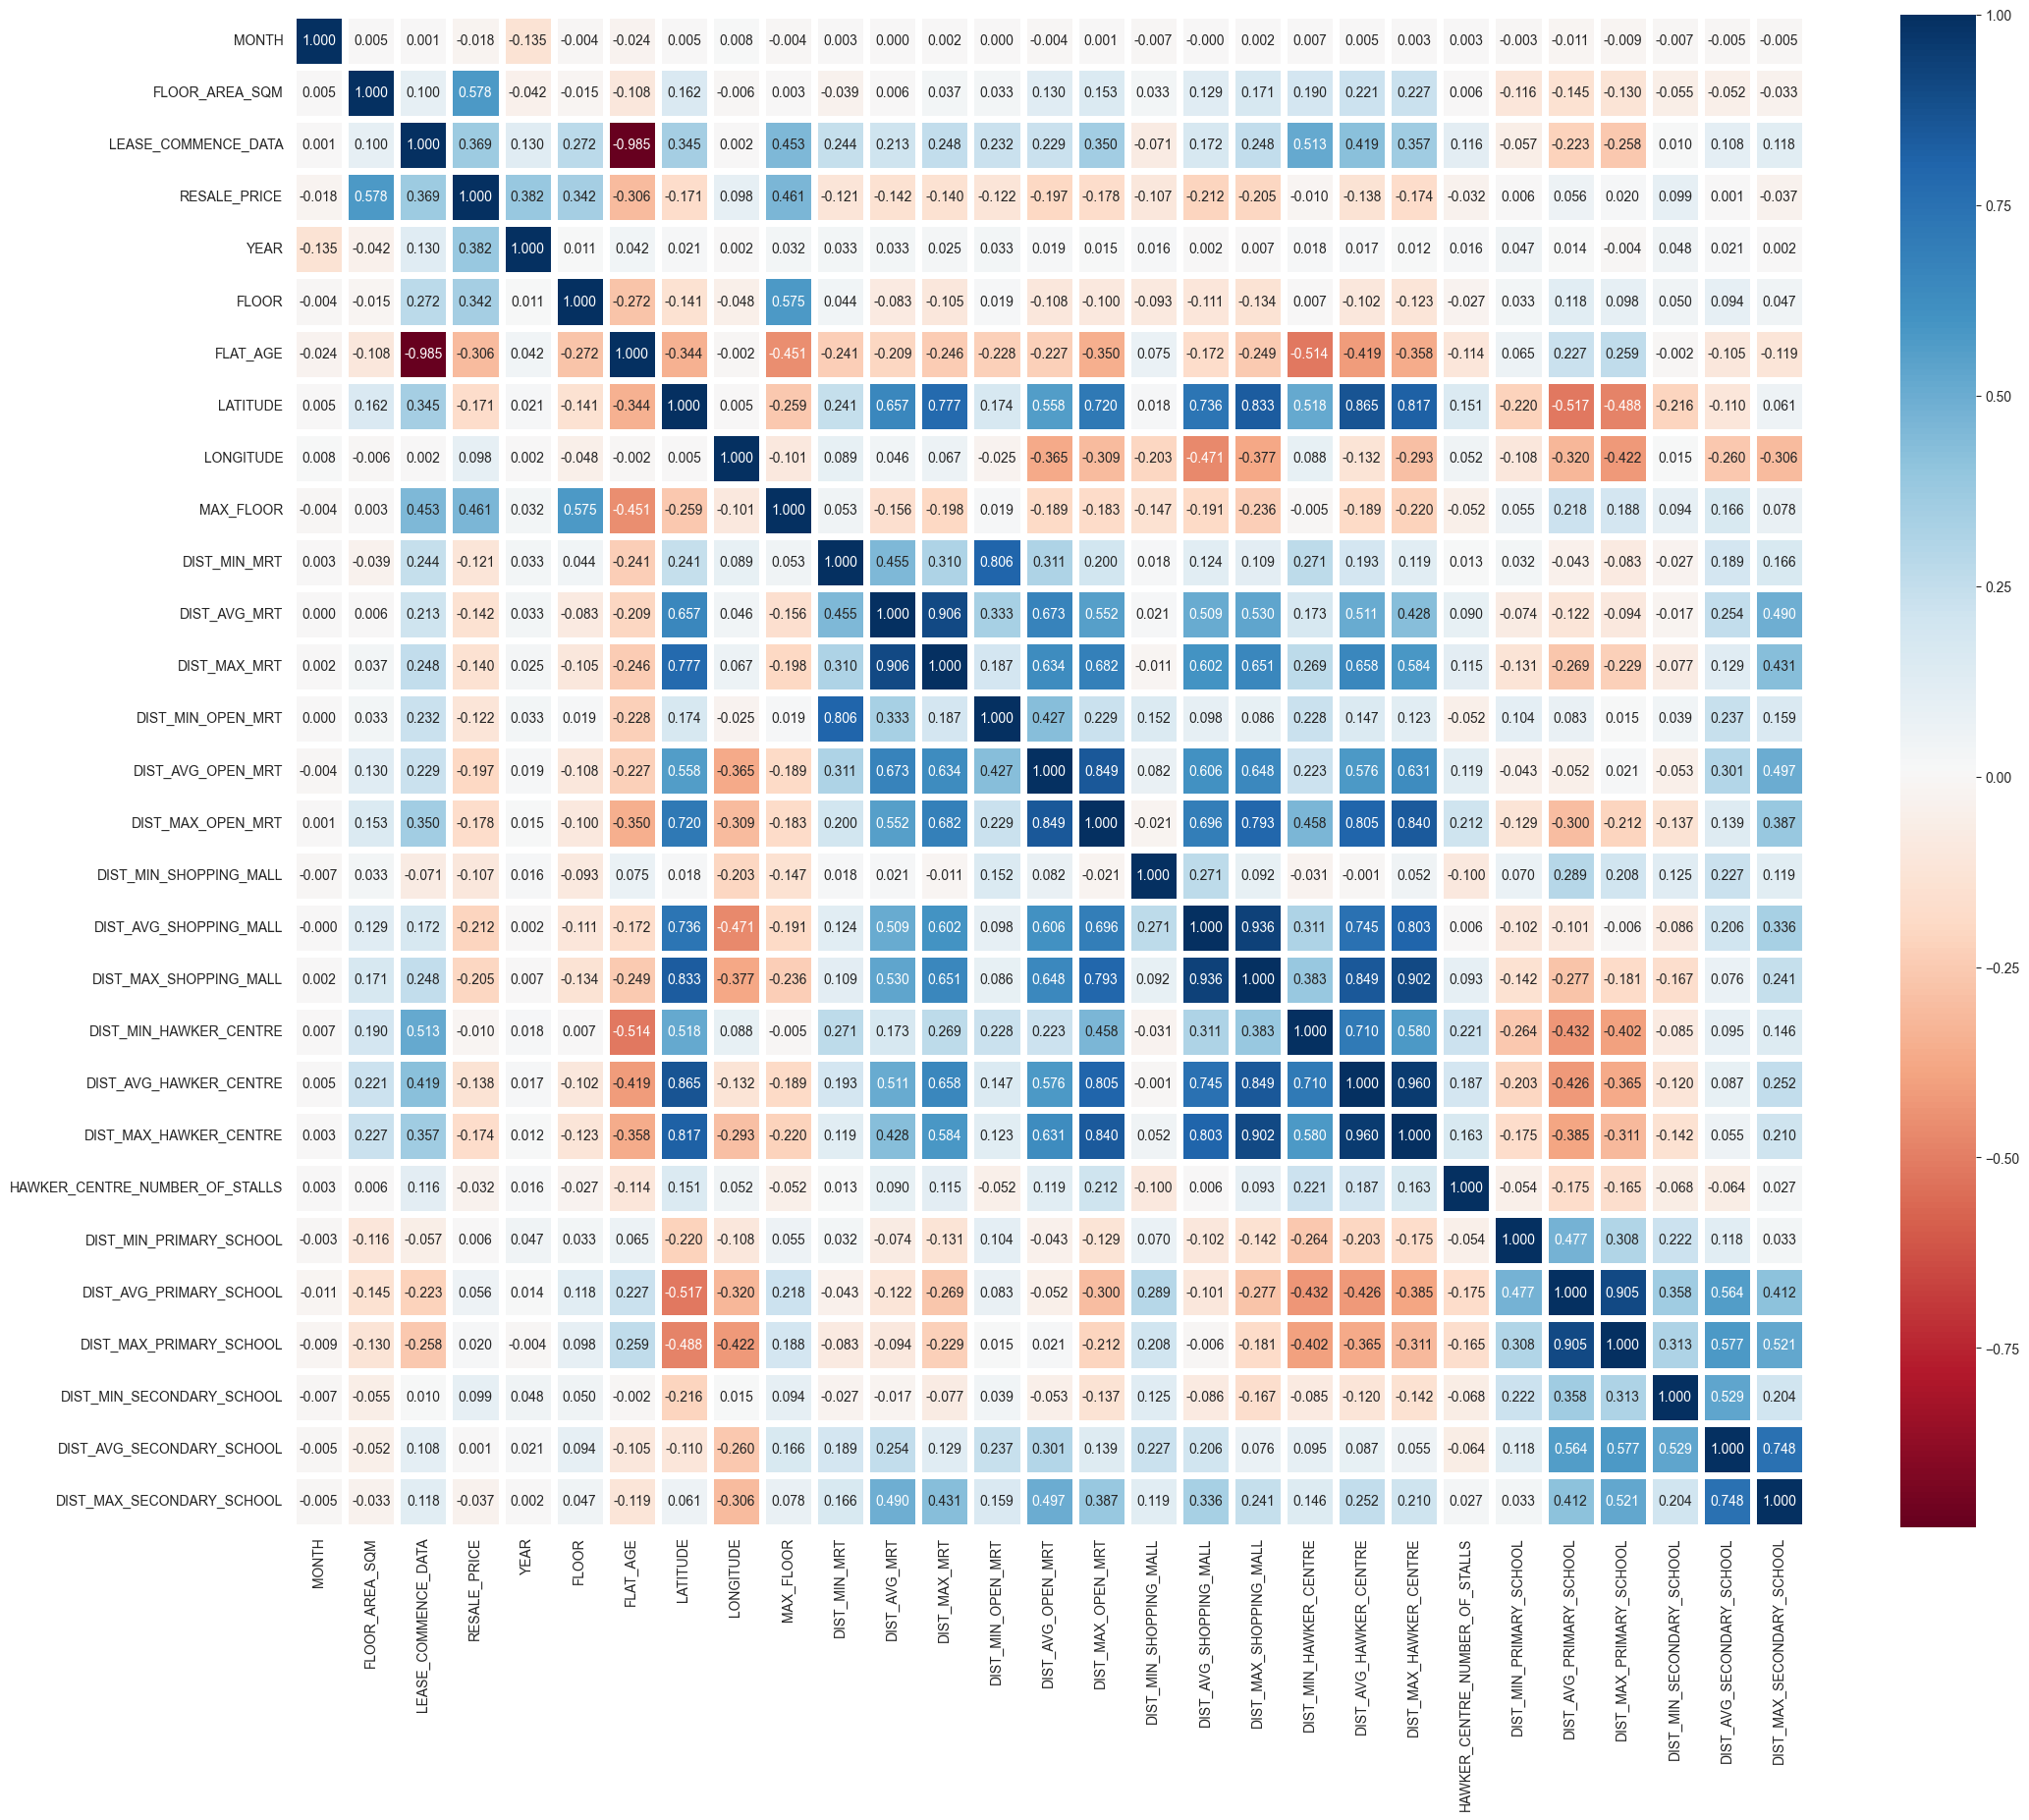

Correlation with RESALE_PRICE:
RESALE_PRICE                      1.000000
FLOOR_AREA_SQM                    0.578184
MAX_FLOOR                         0.460962
YEAR                              0.382024
LEASE_COMMENCE_DATA               0.368649
FLOOR                             0.341696
DIST_MIN_SECONDARY_SCHOOL         0.098628
LONGITUDE                         0.097546
DIST_AVG_PRIMARY_SCHOOL           0.056364
DIST_MAX_PRIMARY_SCHOOL           0.020168
DIST_MIN_PRIMARY_SCHOOL           0.006223
DIST_AVG_SECONDARY_SCHOOL         0.001191
DIST_MIN_HAWKER_CENTRE           -0.009865
MONTH                            -0.018045
HAWKER_CENTRE_NUMBER_OF_STALLS   -0.031772
DIST_MAX_SECONDARY_SCHOOL        -0.037192
DIST_MIN_SHOPPING_MALL           -0.106722
DIST_MIN_MRT                     -0.120673
DIST_MIN_OPEN_MRT                -0.122262
DIST_AVG_HAWKER_CENTRE           -0.137894
DIST_MAX_MRT                     -0.140308
DIST_AVG_MRT                     -0.141902
LATITUDE               

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


df_filtered = df_train.select_dtypes(include=['number'])

datacor=np.corrcoef(df_filtered.values,rowvar=0)
datacor=pd.DataFrame(data=datacor,columns=df_filtered.columns,index=df_filtered.columns)
plt.figure(figsize=(25,20))
ax=sns.heatmap(datacor, square=True, annot=True, fmt=".3f", linewidths=5, cmap='RdBu')
plt.show()

print("Correlation with RESALE_PRICE:")
resale_corr = datacor["RESALE_PRICE"].sort_values(ascending=False)
print(resale_corr)

# Categorical Correlations

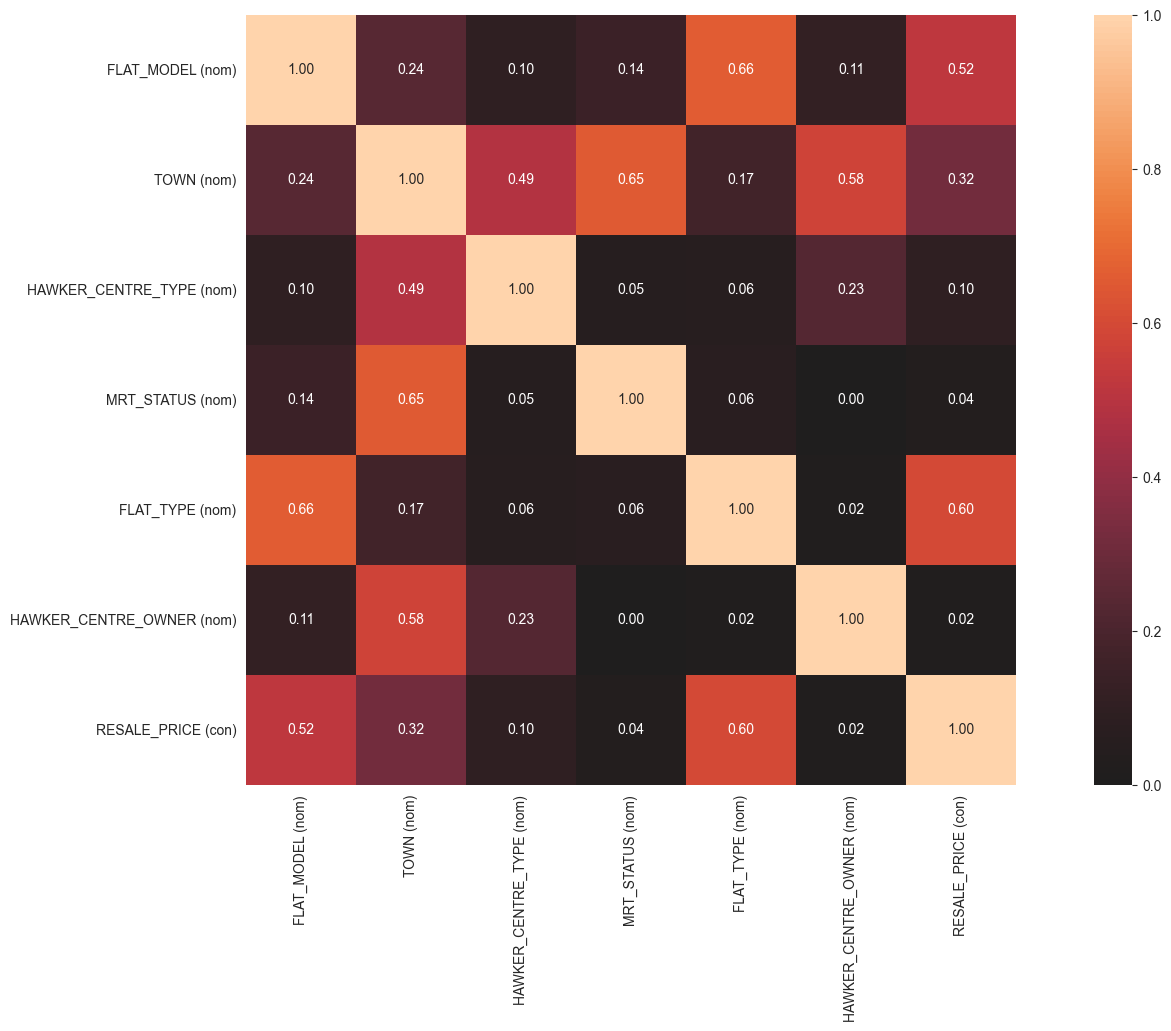

In [16]:
# This calculates the Correlation Ratio for categorical-continuous cases,

from dython import nominal
nominal.associations(df_train[[
    'FLAT_MODEL',
    'TOWN',
    'HAWKER_CENTRE_TYPE',
    'MRT_STATUS',
    'FLAT_TYPE',
    'HAWKER_CENTRE_OWNER',
    'RESALE_PRICE'
]],figsize=(20,10),mark_columns=True);

In [17]:
def correlation_ratio(categories, values):
    mask = ~pd.isnull(categories) & ~pd.isnull(values)
    categories = np.array(categories[mask])
    values = np.array(values[mask])

    category_means = {}
    for cat in np.unique(categories):
        category_means[cat] = np.mean(values[categories == cat])
    overall_mean = np.mean(values)

    numerator = np.sum([
        len(values[categories == cat]) * (mean - overall_mean) ** 2
        for cat, mean in category_means.items()
    ])

    denominator = np.sum((values - overall_mean) ** 2)
    return np.sqrt(numerator / denominator) if denominator != 0 else 0

def plot_categorical_vs_price(df, cat_cols, target_col="RESALE_PRICE"):
    n = len(cat_cols)
    ncols = 3
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 8*nrows))
    axes = axes.flatten()

    for i, feature_name in enumerate(cat_cols):
        ax = axes[i]
        ax2 = ax.twinx()

        order = df.groupby(feature_name)[target_col].mean().sort_values().index

        sns.countplot(
            data=df,
            x=feature_name,
            order=order,
            ax=ax,
            color="lightgray",
            alpha=0.7
        )

        df_grouped = (
            df.groupby(feature_name)[target_col]
              .mean()
              .reindex(order)
              .reset_index()
        )

        sns.lineplot(
            data=df_grouped,
            x=feature_name,
            y=target_col,
            ax=ax2,
            color="teal",
            marker="o",
            linewidth=1.8
        )

        ax.set_title(f"{feature_name}", fontsize=12)
        ax.set_xlabel("")
        ax.set_ylabel("Count")
        ax2.set_ylabel("Avg Resale Price (SGD)")
        ax.tick_params(axis="x", rotation=90)

        for idx, row in df_grouped.iterrows():
            ax2.text(
                idx, row[target_col],
                f"{row[target_col]/1000:.0f}K",
                ha="center", va="bottom",
                fontsize=8, color="teal"
            )

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


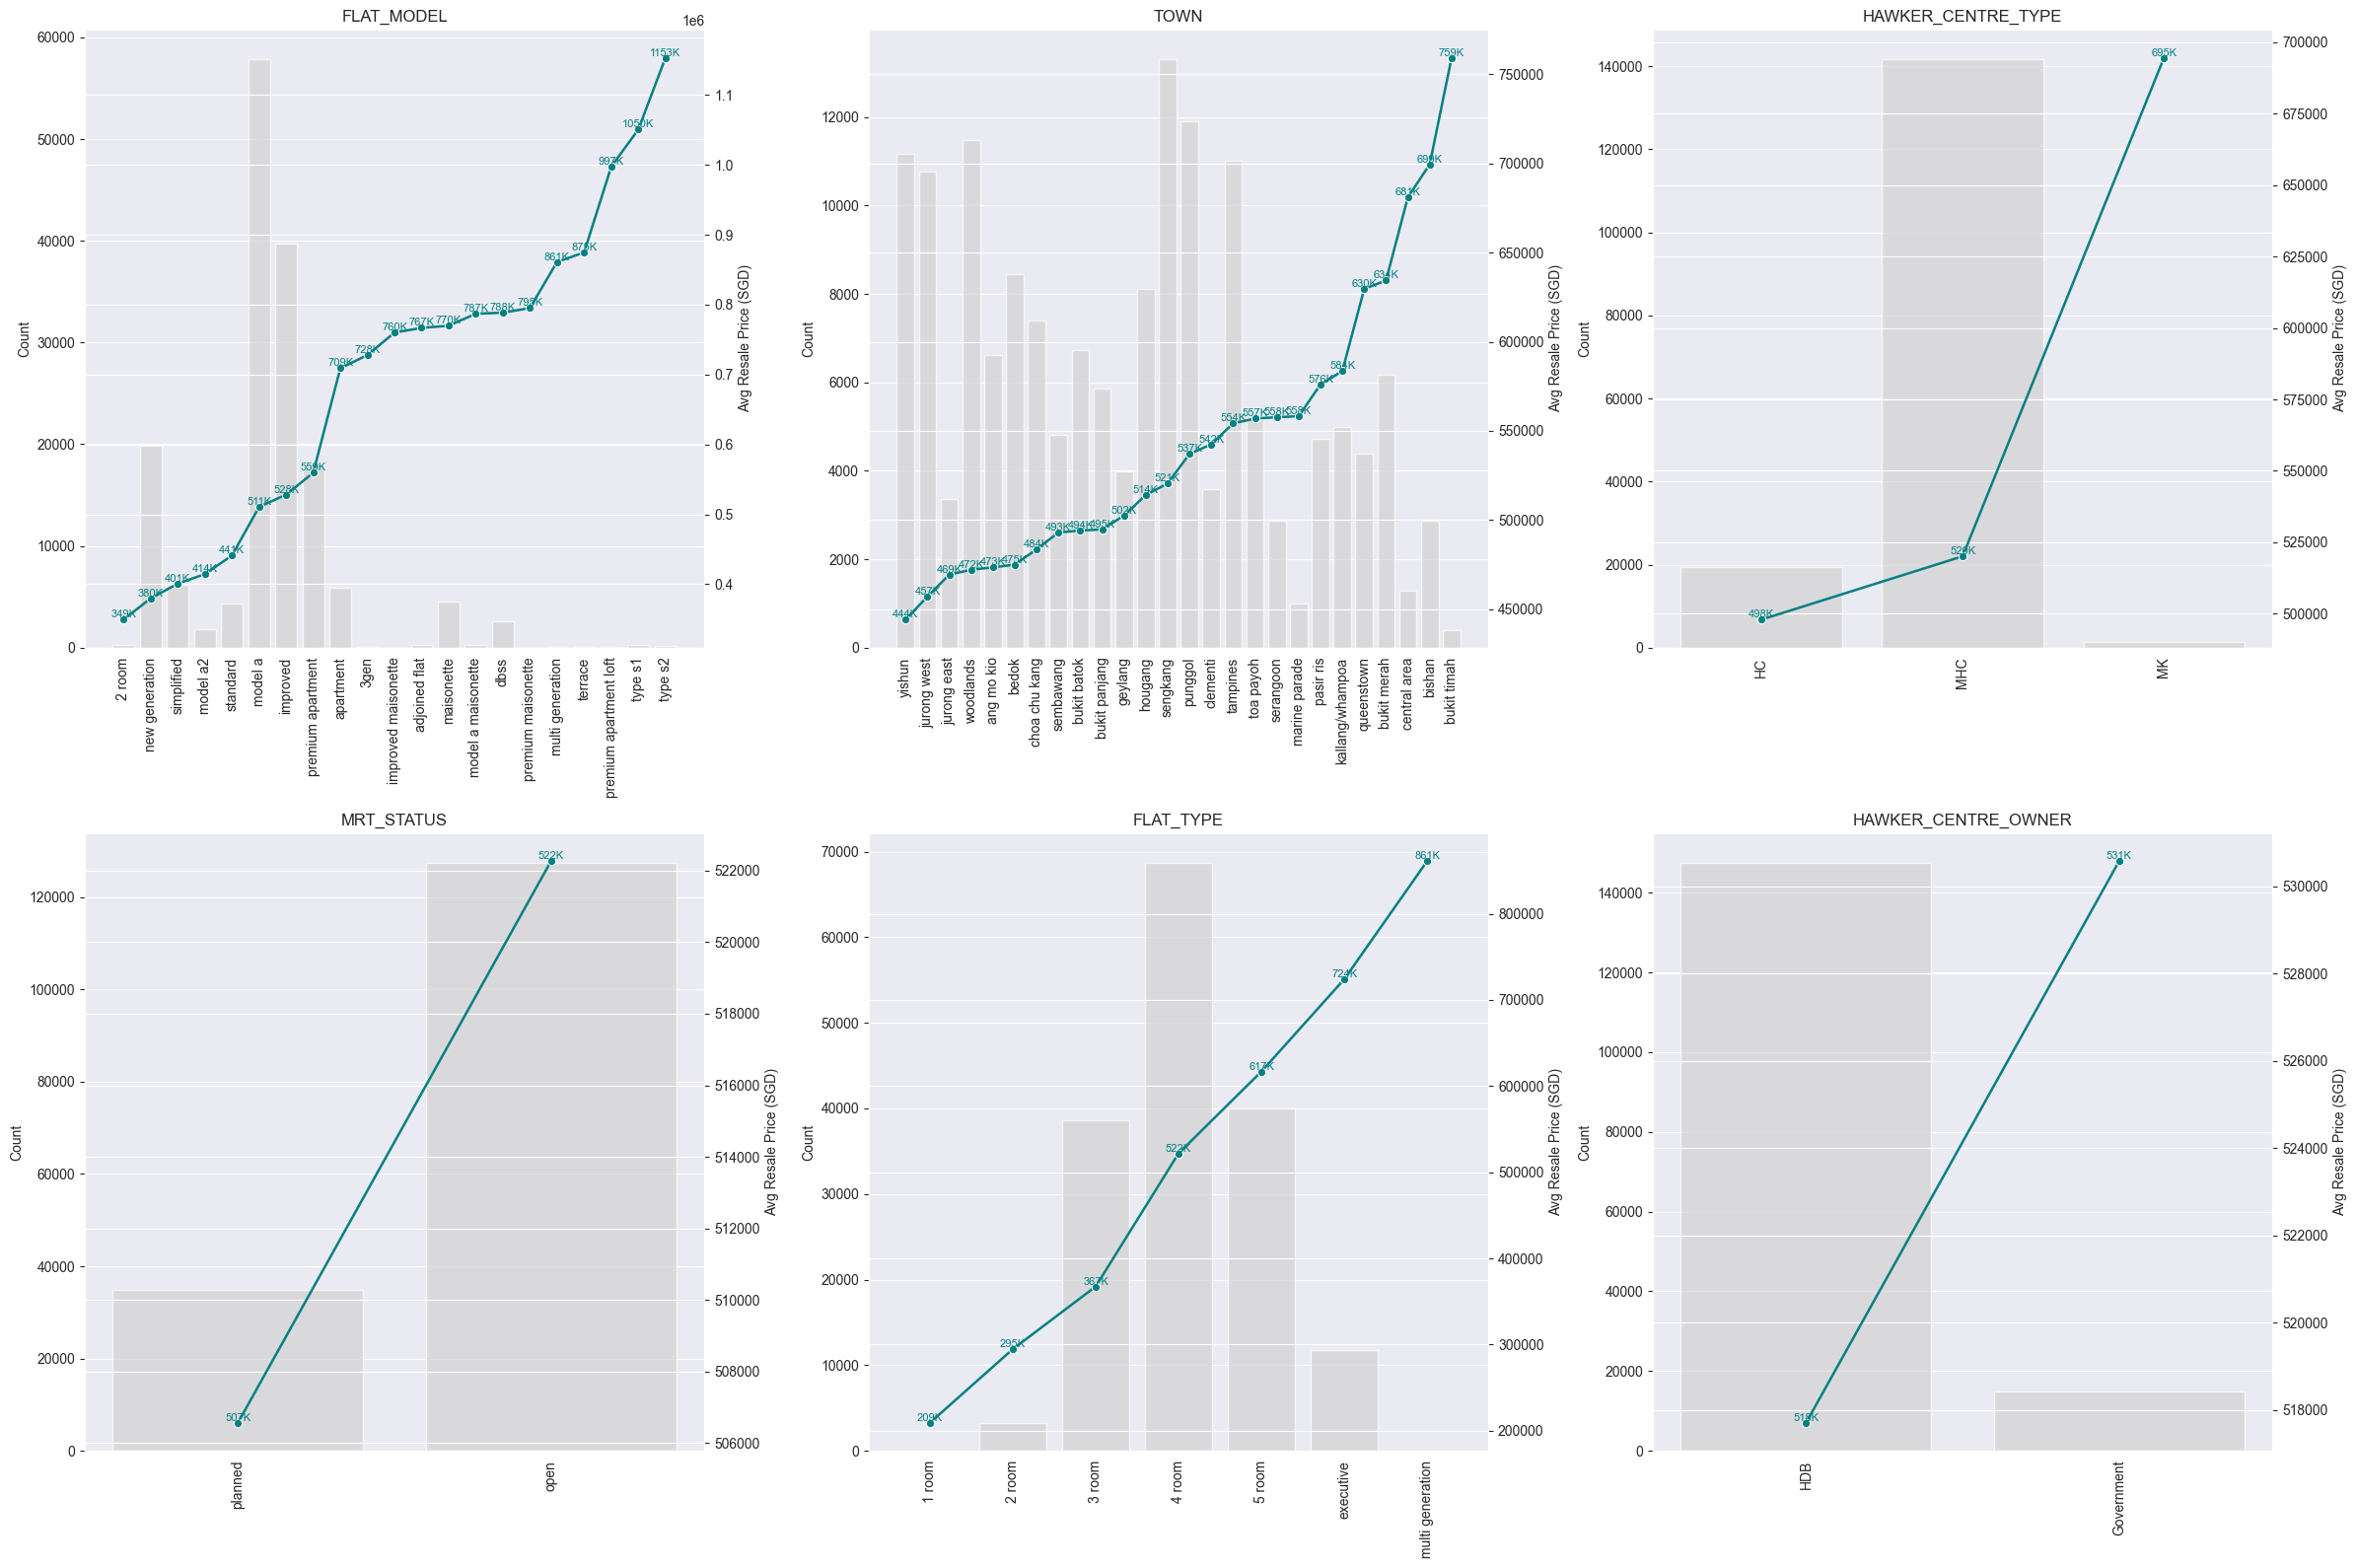

In [18]:
categorical_columns = [
    'FLAT_MODEL',
     'TOWN',
     'HAWKER_CENTRE_TYPE',
     'MRT_STATUS',
     'FLAT_TYPE',
     'HAWKER_CENTRE_OWNER'
]
plot_categorical_vs_price(df_train, categorical_columns)


In [19]:
def boxplot(feature):
    plt.figure(figsize=(14, 7))
    median_sorted = (
        df_train.groupby(feature)['RESALE_PRICE']
        .median()
        .sort_values(ascending=False)
        .index
    )

    sns.boxplot(
        x=feature,
        y='RESALE_PRICE',
        data=df_train,
        order=median_sorted,
        showfliers=False
    )

    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Resale Price (SGD)')
    plt.title(f'Distribution of Resale Prices by {feature} (Boxplot Sorted by Median)')
    plt.tight_layout()
    plt.show()


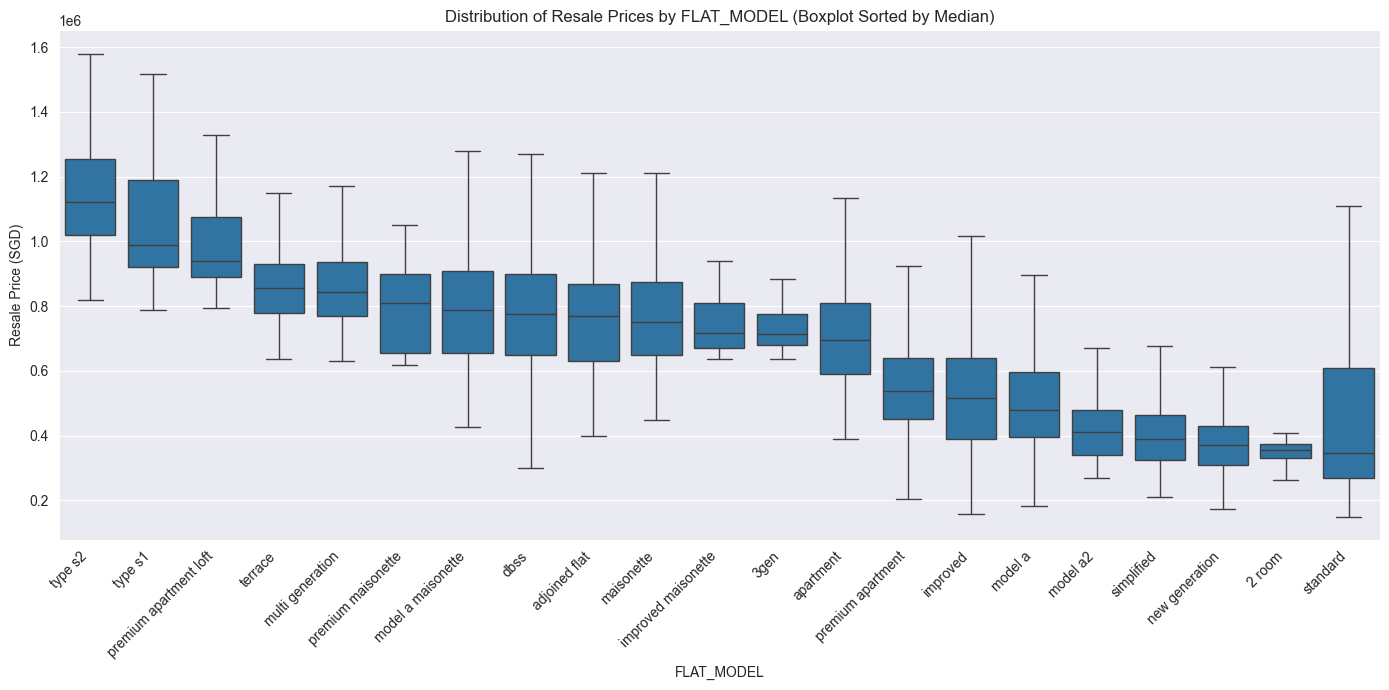

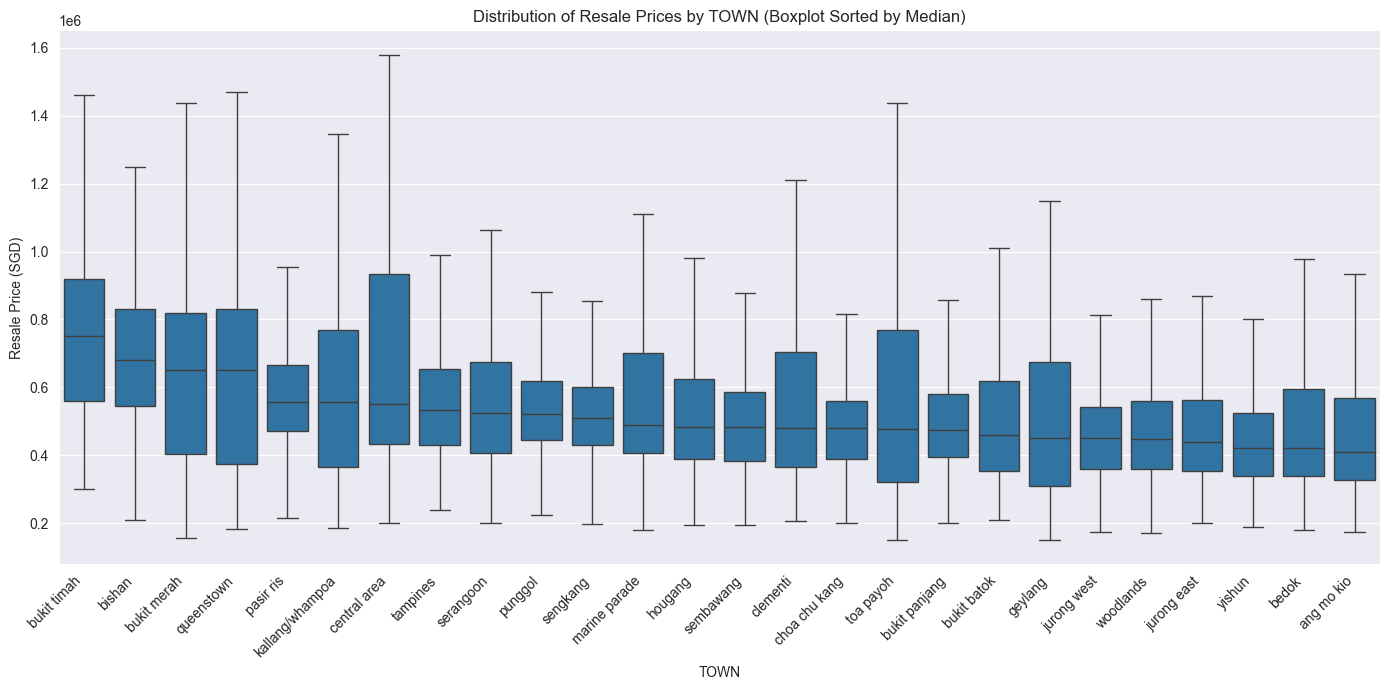

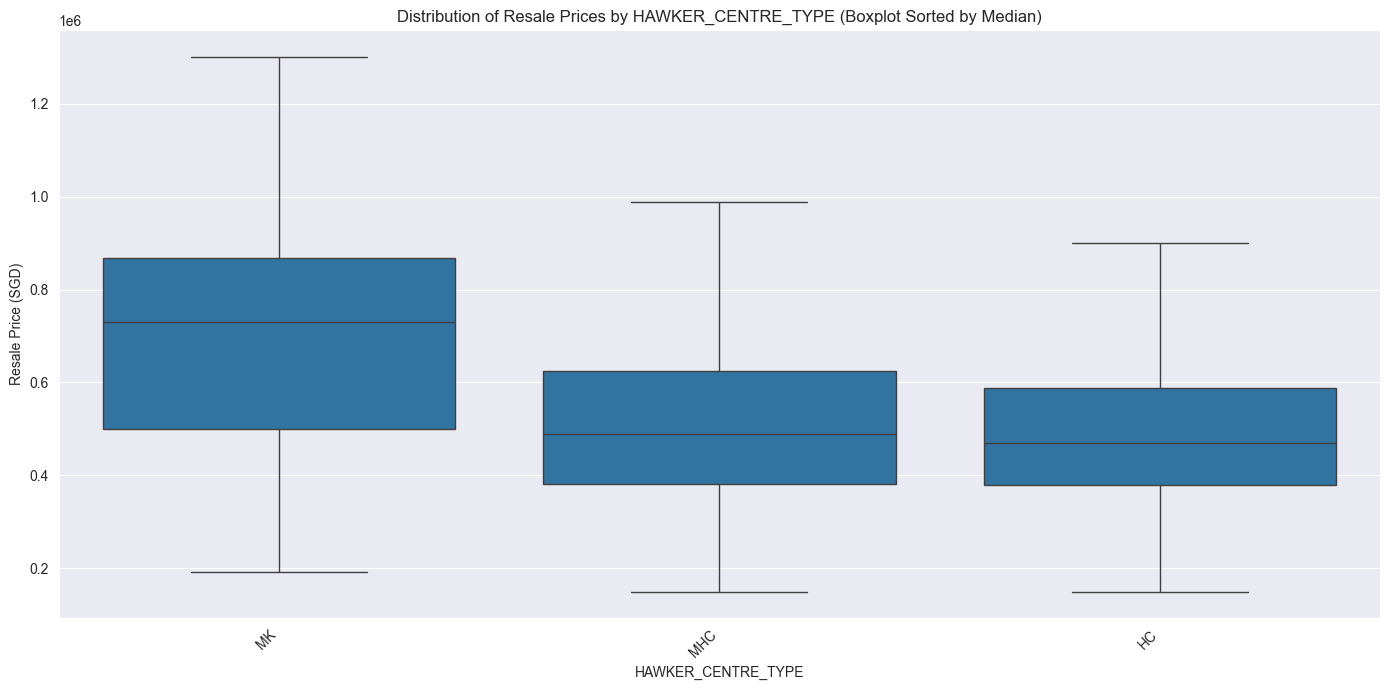

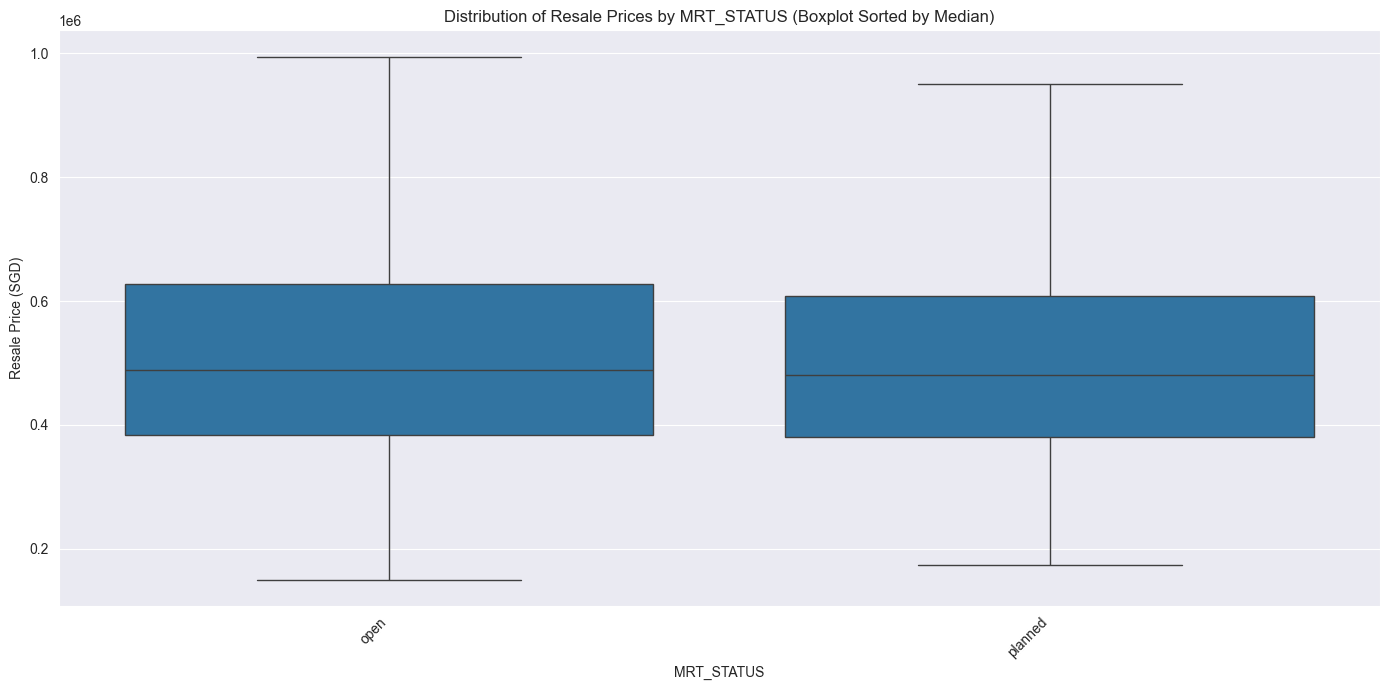

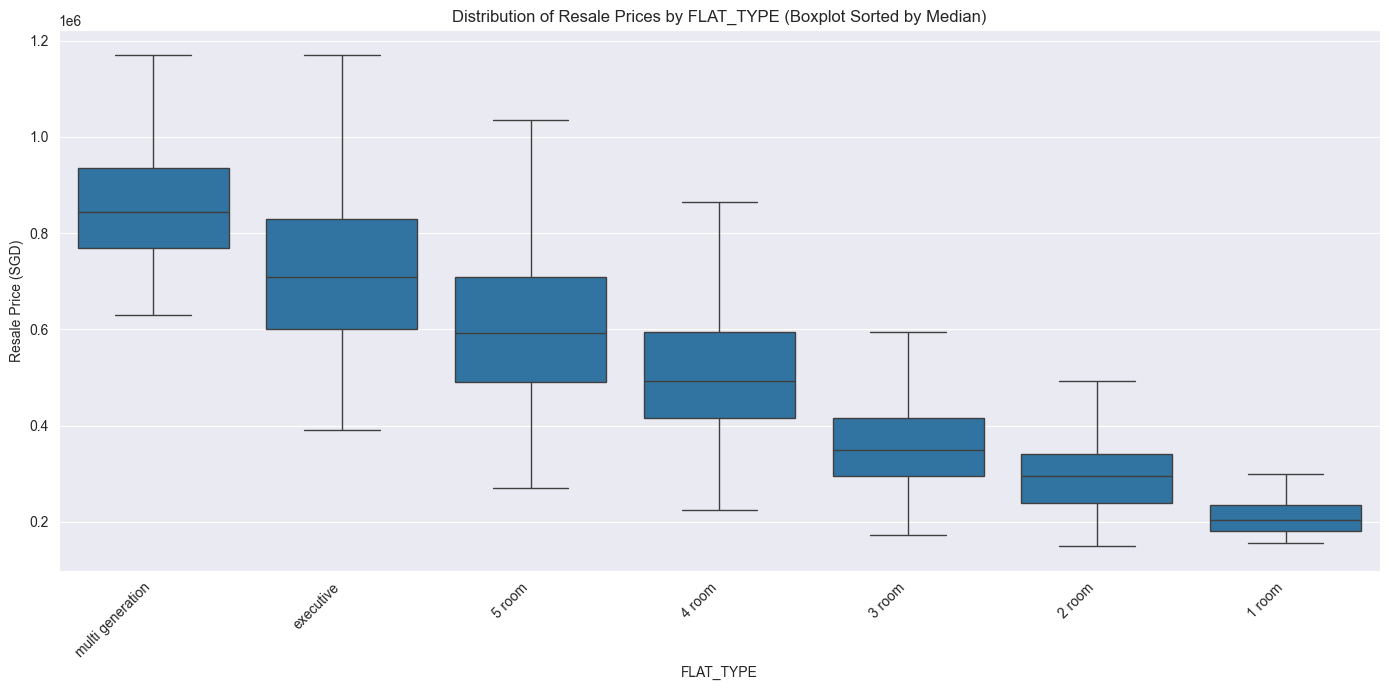

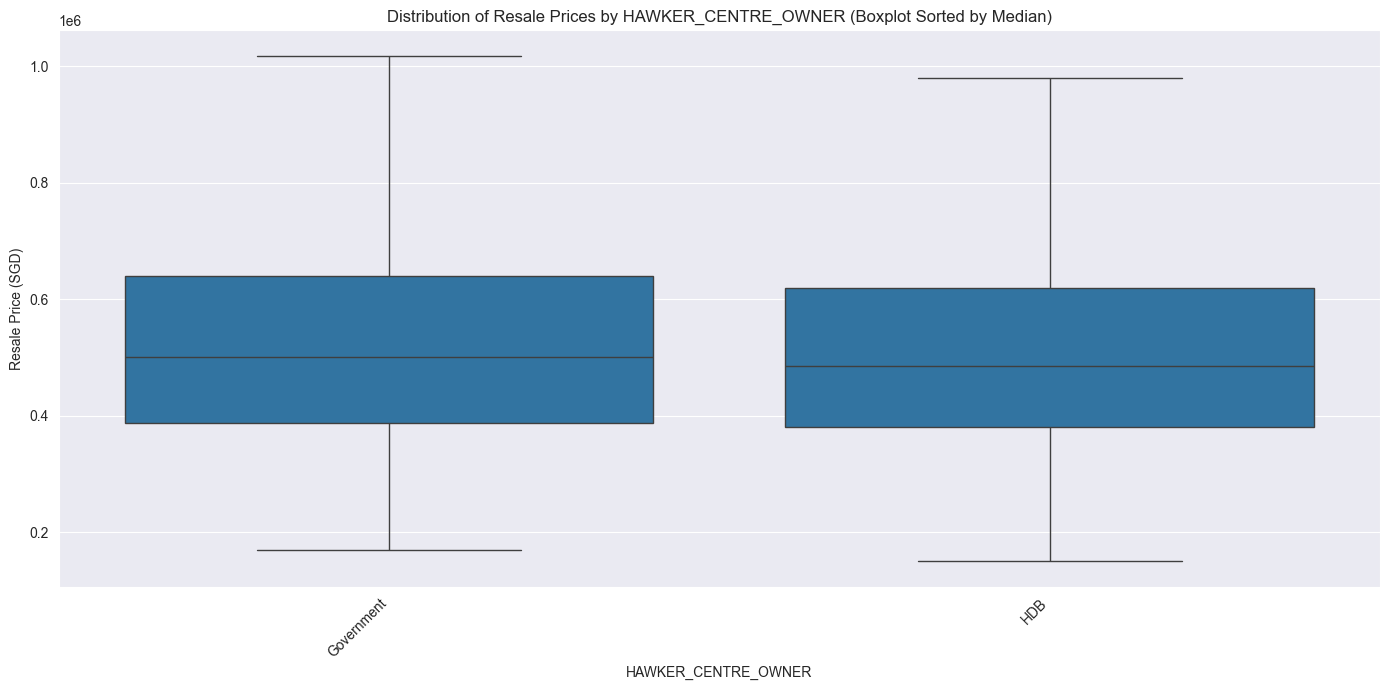

In [20]:
for cat in categorical_columns:
    boxplot(feature=cat)

# Visualization On the Map

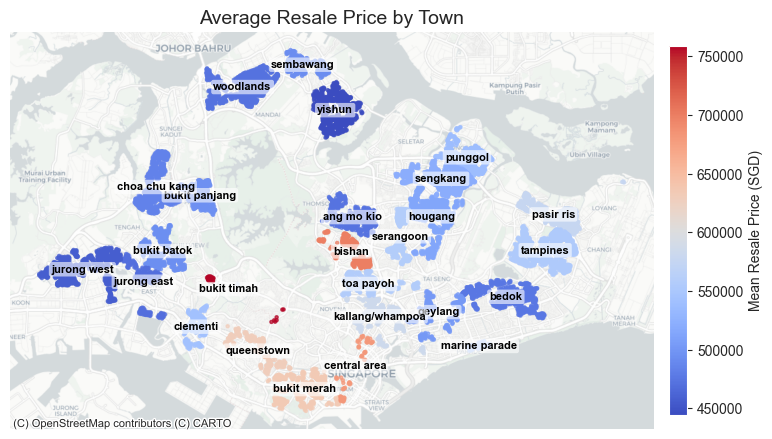

In [21]:
gdf = gpd.GeoDataFrame(
    df_train,
    geometry=gpd.points_from_xy(df_train["LONGITUDE"], df_train["LATITUDE"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

town_avg = (
    gdf.groupby("TOWN")["RESALE_PRICE"]
    .mean()
    .rename("TOWN_MEAN_PRICE")
    .reset_index()
)

town_gdf = gdf.dissolve(by="TOWN", as_index=False)
town_gdf = town_gdf.merge(town_avg, on="TOWN", how="left")

town_gdf["x"] = town_gdf.geometry.centroid.x
town_gdf["y"] = town_gdf.geometry.centroid.y

fig, ax = plt.subplots(figsize=(10, 8))
town_gdf.plot(
    ax=ax,
    column="TOWN_MEAN_PRICE",
    cmap="coolwarm",
    markersize=5,
    alpha=0.7,
    legend=True,
    legend_kwds={
        'shrink': 0.6,
        'pad': 0.02,
        'aspect': 20,
        'label': "Mean Resale Price (SGD)"
    }
)

for _, row in town_gdf.iterrows():
    ax.text(
        row["x"], row["y"], row["TOWN"],
        fontsize=8, fontweight="bold",
        ha="center", va="center",
        color="black",
        bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.2")
    )

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("Average Resale Price by Town", fontsize=14)
ax.axis("off")
plt.show()


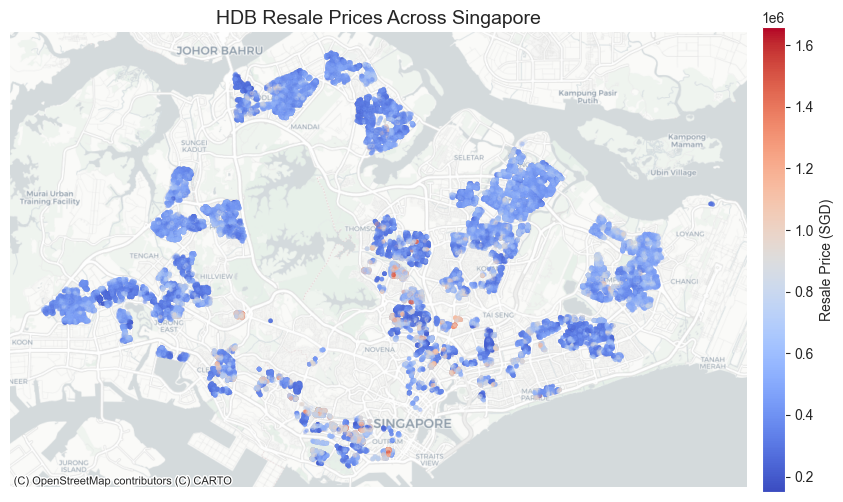

In [22]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import ListedColormap

gdf = gpd.GeoDataFrame(
    df_train,
    geometry=gpd.points_from_xy(df_train["LONGITUDE"], df_train["LATITUDE"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

price_min = gdf["RESALE_PRICE"].min()
price_max = gdf["RESALE_PRICE"].max()
norm = (gdf["RESALE_PRICE"] - price_min) / (price_max - price_min)
norm = np.clip(norm, 0, 1)

# used custom color map to make the expensive priced houses standout
n_colors = 256
colors = []
for v in np.linspace(0, 1, n_colors):
    base_color = plt.cm.coolwarm(v)
    r, g, b, _ = base_color
    alpha = 1 if v ** 2.5 > 0.5 else (0.1 if v ** 2.5 < 0.1 else v ** 2.5)
    colors.append((r, g, b, alpha))
custom_cmap = ListedColormap(colors)

rgba_values = custom_cmap(norm)

fig, ax = plt.subplots(figsize=(10, 8))
gdf.plot(
    ax=ax,
    color=rgba_values,
    markersize=5,
)

sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=price_min, vmax=price_max))
sm._A = []
cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
cbar.set_label("Resale Price (SGD)")

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_title("HDB Resale Prices Across Singapore", fontsize=14)
ax.axis("off")

plt.show()


# Plot Auxiliary data on the map

In [23]:
def plot_hdb_with_secondary(
        df_secondary,
        secondary_label="Secondary Data",
        color="green",
        marker="s",
):
    fig, ax = plt.subplots(figsize=(10, 8))

    gdf_secondary = gpd.GeoDataFrame(
        df_secondary,
        geometry=gpd.points_from_xy(df_secondary["LONGITUDE"], df_secondary["LATITUDE"]),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    gdf = gpd.GeoDataFrame(
        df_train,
        geometry=gpd.points_from_xy(df_train["LONGITUDE"], df_train["LATITUDE"]),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    price_min = gdf["RESALE_PRICE"].min()
    price_max = gdf["RESALE_PRICE"].max()
    norm = (gdf["RESALE_PRICE"] - price_min) / (price_max - price_min)
    norm = np.clip(norm, 0, 1)

    n_colors = 256
    colors = []
    for v in np.linspace(0, 1, n_colors):
        base_color = plt.cm.coolwarm(v)
        r, g, b, _ = base_color
        alpha = 1 if v ** 2.5 > 0.5 else (0.1 if v ** 2.5 < 0.1 else v ** 2.5)
        colors.append((r, g, b, alpha))
    custom_cmap = ListedColormap(colors)

    rgba_values = custom_cmap(norm)

    gdf.plot(
        ax=ax,
        color=rgba_values,
        markersize=5,
    )

    gdf_secondary.plot(
        ax=ax,
        color=color,
        markersize=18,
        marker=marker,
        label=secondary_label,
        alpha=0.8
    )

    sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=price_min, vmax=price_max))
    sm._A = []
    cbar = plt.colorbar(sm, ax=ax, fraction=0.03, pad=0.02)
    cbar.set_label("Resale Price (SGD)")


    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.legend(
        loc="lower left",
        frameon=True,
        fontsize=9,
        facecolor="white",
        framealpha=0.8
    )

    ax.set_title(f"Resale Price Clusters with {secondary_label}", fontsize=14)
    ax.axis("off")

    plt.show()



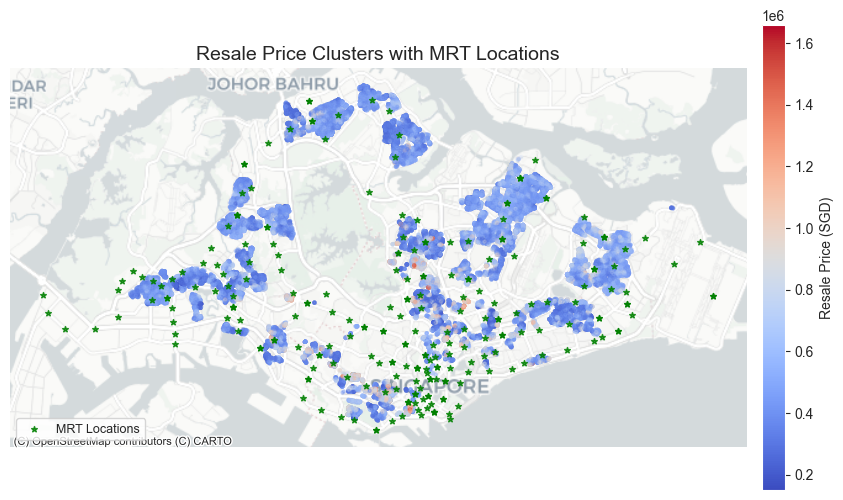

In [24]:
plot_hdb_with_secondary(df_mrt, secondary_label="MRT Locations", color="green", marker="*")

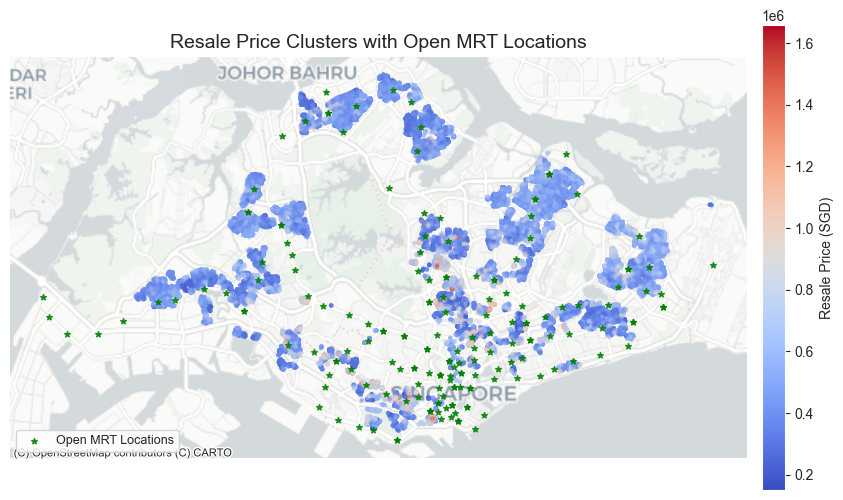

In [25]:
plot_hdb_with_secondary(df_mrt[df_mrt["STATUS"] == "open"], secondary_label="Open MRT Locations", color="green", marker="*")

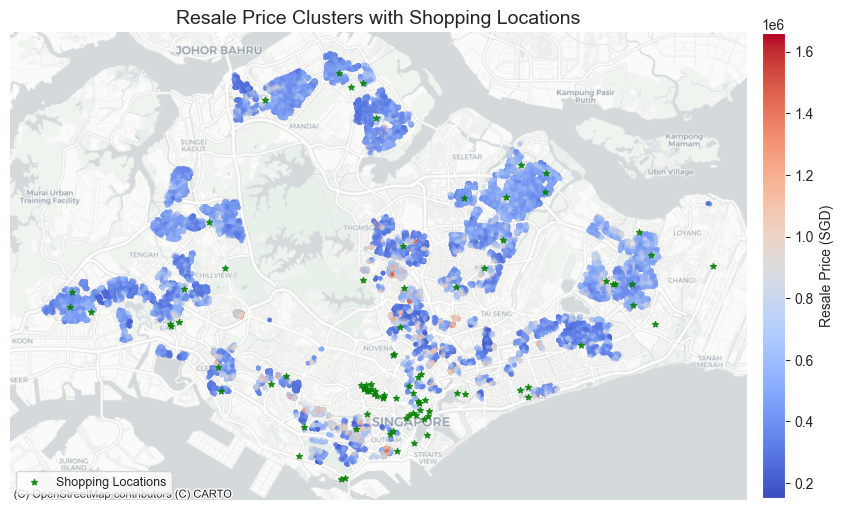

In [26]:
plot_hdb_with_secondary(df_shopping, secondary_label="Shopping Locations", color="green", marker="*")

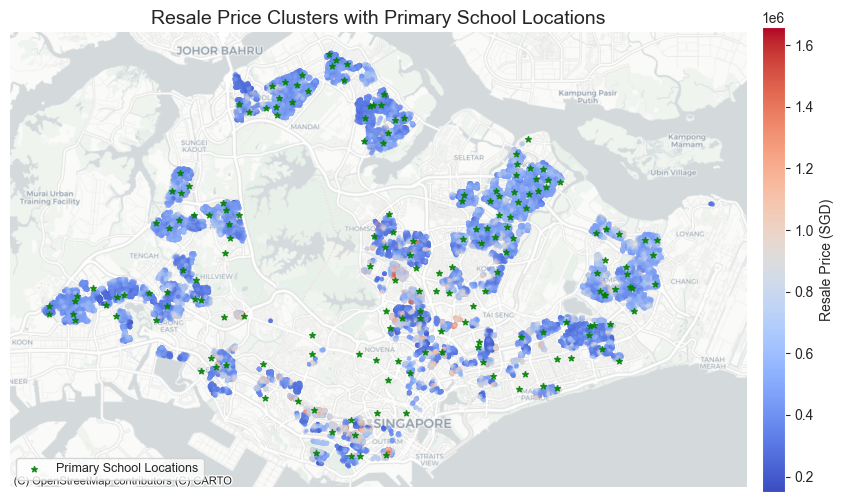

In [27]:
plot_hdb_with_secondary(df_primary_schools, secondary_label="Primary School Locations", color="green", marker="*")

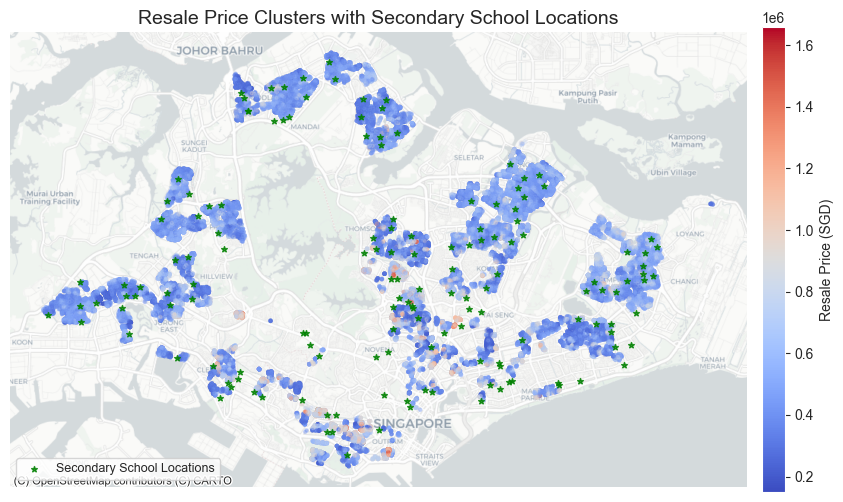

In [28]:
plot_hdb_with_secondary(df_secondary_schools, secondary_label="Secondary School Locations", color="green", marker="*")

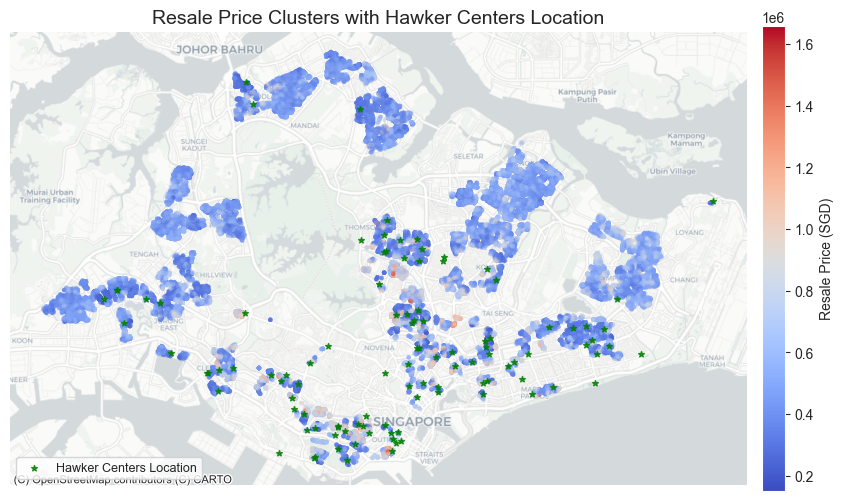

In [29]:
plot_hdb_with_secondary(df_hawker, secondary_label="Hawker Centers Location", color="green", marker="*")

# Sources
1. https://shakedzy.xyz/dython/modules/nominal/ (categorical-continuous features)
2. https://melaniesoek0120.medium.com/data-visualization-how-to-plot-a-map-with-geopandas-in-python-73b10dcd4b4b (Plotting on GeoPandas)
3. https://medium.com/@gagan.2492/sweetviz-automated-exploratory-data-analysis-eda-in-python-cfae77613e72 (SweetViz for guidance on EDA)